In [1]:
# IMPORT DEPENDANCIES

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import numpy as np
from scipy import stats
from scipy import integrate
from IPython.display import HTML, display
from scipy.stats import norm
from scipy.stats import t as the
from flask import Flask, jsonify

%matplotlib inline
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)

In [2]:
from notebook.services.config import ConfigManager
ConfigManager().update('notebook', {'ExecuteTime': {
    'display_absolute_timestamps': True,
    'relative_timing_update_period': 5,
    'template': {
        'executed': 'started ${start_time}, finished in ${duration}',
    }
}})



{'Notebook': {'Header': True},
 'ExecuteTime': {'display_absolute_timestamps': True,
  'relative_timing_update_period': 5,
  'template': {'executed': 'started ${start_time}, finished in ${duration}'}}}

In [3]:
# DEFINE ACTIVITIES

activity_id = {0: 'transient', 1:'lying', 2:'sitting', 3:'standing',
              4:'walking', 5:'running', 6:'cycling', 7:'Nordic walking',
              9:'watching TV', 10:'computer work', 11:'car driving',
              12:'ascending stairs', 13:'descending stairs', 16:'vacuum cleaning',
              17:'ironing', 18:'folding laundry', 19:'house cleaning',
              20:'playing soccer', 24:'rope jumping'}

#Protocol Activities: lie, sit, stand, walk, run, cycle, Nordic walk, iron, vacuum cleaning, 
#rope jump, ascend and descend stairs
protocol_acts = [1,2,3,4,5,6,7,17,16,24,12,13]

#Optional Activities: watch TV, computer work, drive car, fold laundry, house cleaning, play soccer
optional_acts = [9,10,11,18,19,20]

#Soldier Activities: transient, lying, sitting, standing, walking, running, hiking, operating C2, operating vehicle,
#ascending stairs, descending stairs, jumping (rope), and house cleaning (misc tasks)
soldier_acts = [1,2,3,4,5,7,10,11,12,13,24,19]

#MET Classification of activities as low, medium, or high

#lying, sitting, and standing
low_activity = [1,2,3,17]
#descending stairs, walking, Nordic walking (hiking), and house cleaning (misc tasks)
medium_activity = [4,6,7,13,16, 19]
#ascending stairs, running, and jumping (rope)
high_activity = [5,12,24]


def map_met(act_id):
    if act_id in low_activity:
        return 'low'
    if act_id in medium_activity:
        return 'medium'
    if act_id in high_activity:
        return 'high'
    
col_names=['timestamp', 'activity_id', 'heart_rate']

IMU_locations = ['hand', 'chest', 'ankle']
IMU_data = ['tmp', 'acc_16_01', 'acc_16_02', 'acc_16_03',
            'acc_06_01', 'acc_06_02', 'acc_06_03',
            'gyr_01', 'gyr_02', 'gyr_03',
            'mag_01', 'mag_02', 'mag_03',
            'ori_01', 'ori_02', 'ori_03', 'ori_04']

col_names = col_names + [item for sublist in [[dat+'_'+loc for dat in IMU_data] for loc in IMU_locations] for item in sublist]

In [4]:
# LOAD DATA

files = [
    'PAMAP2_Dataset/Protocol/subject101.dat',
    'PAMAP2_Dataset/Protocol/subject102.dat',
    'PAMAP2_Dataset/Protocol/subject103.dat',
    'PAMAP2_Dataset/Protocol/subject104.dat',
    'PAMAP2_Dataset/Protocol/subject105.dat',
    'PAMAP2_Dataset/Protocol/subject106.dat',
    'PAMAP2_Dataset/Protocol/subject107.dat',
    'PAMAP2_Dataset/Protocol/subject108.dat',
    'PAMAP2_Dataset/Protocol/subject109.dat'
]

pamap2 = pd.DataFrame()

for file in files:
    sub_data = pd.read_table(file, header=None, sep='\s+')
    sub_data.columns = col_names
    sub_data['sub_id'] = int(file[-5])
    sub_data['act_level'] = sub_data['activity_id'].apply(map_met)
    pamap2 = pamap2.append(sub_data, ignore_index=True)
    

In [5]:
# THIN OUT DATA

drop_index = []

#Getting indexes of activity 0
drop_index += list(pamap2.index[pamap2['activity_id']==0])

#Keep only activities as documented on file "PerformedActivitiesSummary.pdf"
drop_index += list(pamap2.index[(pamap2['sub_id']==1) & (pamap2['activity_id'].isin([10,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==2) & (pamap2['activity_id'].isin([9,10,11,18,19,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==3) & (pamap2['activity_id'].isin([5,6,7,9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==4) & (pamap2['activity_id'].isin([5,9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==5) & (pamap2['activity_id'].isin([9,11,18,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==6) & (pamap2['activity_id'].isin([9,11,20]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==7) & (pamap2['activity_id'].isin([9,10,11,18,19,20,24]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==8) & (pamap2['activity_id'].isin([9,11]))])
drop_index += list(pamap2.index[(pamap2['sub_id']==9) & (pamap2['activity_id'].isin([1,2,3,4,5,6,7,9,11,12,13,16,17]))])

pamap2 = pamap2.drop(drop_index)
    
#Interpolate data
pamap2 = pamap2.interpolate()


In [6]:
# CLEAN DATA

freq = 100
pamap2['act_block'] = ((pamap2['activity_id'].shift(1) != pamap2['activity_id']) | (pamap2['sub_id'].shift(1) != pamap2['sub_id'])).astype(int).cumsum()
drop_index = []
numblocks = pamap2['act_block'].max()
for block in range(1, numblocks+1):
    drop_index += list(pamap2[pamap2['act_block']==block].head(10 * freq).index)
    drop_index += list(pamap2[pamap2['act_block']==block].tail(10 * freq).index)
    
pamap2 = pamap2.drop(drop_index)


In [7]:
pamap2.head(100)


,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_level,act_block
3928,47.66,1,103.0,30.5,-7.76319,-6.59656,0.831271,-7.59876,-6.81413,0.952719,-0.023345,-0.094827,0.200758,11.67170,53.3611,-20.7827,1.0,0.0,0.0,0.0,32.3125,-1.428290,4.59099,-9.911060,-1.667120,4.60909,-9.668380,-1.696650,0.073002,0.284169,44.5122,-11.2486,51.24430,1.0,0.0,0.0,0.0,30.875,9.356030,1.448820,-3.44087,9.482080,1.661260,-3.42233,0.100157,-0.328539,0.148857,-74.7494,-45.4312,-41.3917,1.0,0.0,0.0,0.0,1,low,1
3929,47.67,1,103.0,30.5,-7.96283,-6.78714,0.559511,-7.81101,-6.84291,0.832193,0.119344,-0.173491,0.228492,10.79910,53.7261,-19.8429,1.0,0.0,0.0,0.0,32.3125,-1.302410,4.63088,-9.521700,-1.621060,4.68434,-9.592870,-1.778710,0.069577,0.317669,44.0021,-12.7925,50.86680,1.0,0.0,0.0,0.0,30.875,9.457720,1.108960,-3.74644,9.407290,1.449600,-3.33044,0.022160,-0.316792,0.150338,-76.0839,-46.1565,-41.3886,1.0,0.0,0.0,0.0,1,low,1
3930,47.68,1,103.0,30.5,-7.56159,-6.94546,0.181182,-7.78390,-6.97924,0.605953,0.293628,-0.223687,0.237504,10.24440,53.4288,-19.6083,1.0,0.0,0.0,0.0,32.3125,-1.109250,4.74376,-9.441130,-1.484310,4.77441,-9.457420,-1.757580,0.041567,0.325210,44.5969,-13.3610,49.77180,1.0,0.0,0.0,0.0,30.875,8.735770,0.508215,-4.02024,9.136370,0.920061,-3.41811,0.000155,-0.259867,0.156328,-75.4083,-45.9693,-40.6494,1.0,0.0,0.0,0.0,1,low,1
3931,47.69,1,103.0,30.5,-7.27130,-7.14018,-0.121712,-7.59227,-7.11690,0.228539,0.516965,-0.241007,0.224821,9.80950,52.9010,-18.9146,1.0,0.0,0.0,0.0,32.3125,-1.178960,5.04652,-9.249770,-1.437260,4.86454,-9.230760,-1.841740,-0.005494,0.366242,44.5062,-13.9122,49.27940,1.0,0.0,0.0,0.0,30.875,9.520780,0.959822,-4.13076,8.820060,0.798751,-3.61280,-0.003502,-0.218614,0.199243,-76.1764,-46.5085,-39.5349,1.0,0.0,0.0,0.0,1,low,1
3932,47.70,1,103.0,30.5,-7.19573,-6.95140,-0.159704,-7.24956,-7.30087,-0.058323,0.646473,-0.272410,0.216307,9.98846,52.2646,-21.0066,1.0,0.0,0.0,0.0,32.3125,-1.287090,5.23644,-9.058740,-1.480140,5.07573,-9.078760,-1.853510,-0.055315,0.391737,44.3054,-14.8072,50.13320,1.0,0.0,0.0,0.0,30.875,9.255100,0.886508,-4.24880,9.344720,1.101010,-3.90413,-0.015711,-0.279977,0.195484,-76.4170,-45.6111,-40.0185,1.0,0.0,0.0,0.0,1,low,1
3933,47.71,1,103.0,30.5,-7.34474,-7.02544,-0.084712,-7.21878,-7.19540,-0.088787,0.756132,-0.291966,0.195382,9.54110,51.5274,-20.8937,1.0,0.0,0.0,0.0,32.3125,-1.099990,5.64900,-9.211580,-1.447590,5.37739,-8.987400,-1.869250,-0.077624,0.466869,45.1543,-16.0502,48.55090,1.0,0.0,0.0,0.0,30.875,9.036870,0.619902,-3.97926,8.983960,0.949629,-3.94713,0.009023,-0.256057,0.232798,-76.3084,-45.7171,-40.6394,1.0,0.0,0.0,0.0,1,low,1
3934,47.72,1,103.0,30.5,-7.67549,-6.83110,0.140603,-7.47258,-7.11786,0.122713,0.845222,-0.310498,0.164195,9.64515,52.3992,-21.4642,1.0,0.0,0.0,0.0,32.3125,-1.163040,5.87801,-8.787530,-1.354790,5.70913,-8.911440,-1.934730,-0.075978,0.495424,44.9454,-16.6042,48.79210,1.0,0.0,0.0,0.0,30.875,9.521000,0.579494,-4.05122,9.059700,0.738100,-3.78037,-0.018201,-0.281838,0.237998,-76.0727,-45.6361,-39.0313,1.0,0.0,0.0,0.0,1,low,1
3935,47.73,1,103.0,30.5,-7.79208,-6.52806,-0.016116,-7.59137,-6.87540,0.092102,0.985834,-0.254816,0.122707,10.18830,51.1769,-21.9465,1.0,0.0,0.0,0.0,32.3125,-1.088800,5.99021,-8.864000,-1.292540,5.96546,-8.835510,-1.972350,-0.149502,0.515534,43.5176,-17.7776,47.91080,1.0,0.0,0.0,0.0,3

In [8]:
# DEFINE WINDOWS AND FEATURES

freq = 100
windowsize = int(5.12 * freq)
displacement = 1*freq

#columns used for analysis
columns_used = ['sub_id', 'activity_id', 'act_level', 'heart_rate',
                'tmp_hand','acc_16_01_hand','acc_16_02_hand','acc_16_03_hand',
                'gyr_01_hand','gyr_02_hand','gyr_03_hand',
                'tmp_chest','acc_16_01_chest','acc_16_02_chest','acc_16_03_chest',
                'gyr_01_chest','gyr_02_chest','gyr_03_chest',
                'tmp_ankle','acc_16_01_ankle','acc_16_02_ankle','acc_16_03_ankle',
                'gyr_01_ankle','gyr_02_ankle','gyr_03_ankle']

#resting HR for participating subjects, used for normalisation
sub_rest_hr = {1:75, 2:74, 3:68, 4:58, 5:70, 6:60, 7:60, 8:66, 9:54}

windows = []

#Sliding window of 5.12 seconds, equaling 512 instances of data, with 1 second of overlap
for block in range(1, numblocks+1):
    ar = np.array(pamap2[pamap2['act_block']==block][columns_used])
    start_index = 0
    while True:
        if len(ar[start_index:start_index+windowsize,:])<512:
            break
        windows.append(ar[start_index:start_index+windowsize,:])
        start_index += displacement

#Next the features for each window are calculated
window_features = []
for window in windows:
    features = []
    #Adding Subject ID, Activity ID and Activity Level for ground truth
    features.append(window[0][0])
    features.append(window[0][1])
    features.append(window[0][2])
    #Computing mean, normalised mean and std for HR data
    features.append(np.mean(window[:,3]))
    features.append(np.mean(window[:,3]/sub_rest_hr[window[0][0]]))
    features.append(np.std(window[:,3]))
    features.append(np.std(window[:,3]/sub_rest_hr[window[0][0]]))
    #Computing mean and std for the rest of the columns
    for col in range(4,25):
        features.append(np.mean(window[:,col]))
        features.append(np.std(window[:,col]))
    #Computing correlation between axes for hand Accelerometer    
    features.append(stats.spearmanr(window[:,5],window[:,6])[0])
    features.append(stats.spearmanr(window[:,6],window[:,7])[0])
    features.append(stats.spearmanr(window[:,5],window[:,7])[0])
    #Computing correlation between axes for chest Accelerometer  
    features.append(stats.spearmanr(window[:,12],window[:,13])[0])
    features.append(stats.spearmanr(window[:,13],window[:,14])[0])
    features.append(stats.spearmanr(window[:,12],window[:,14])[0])
    #Computing correlation between axes for ankle Accelerometer
    features.append(stats.spearmanr(window[:,19],window[:,20])[0])
    features.append(stats.spearmanr(window[:,20],window[:,21])[0])
    features.append(stats.spearmanr(window[:,19],window[:,21])[0])
    #Computing correlation between axes for hand Gyroscope    
    features.append(stats.spearmanr(window[:,8],window[:,9])[0])
    features.append(stats.spearmanr(window[:,9],window[:,10])[0])
    features.append(stats.spearmanr(window[:,8],window[:,10])[0])
    #Computing correlation between axes for chest Gyroscope  
    features.append(stats.spearmanr(window[:,15],window[:,16])[0])
    features.append(stats.spearmanr(window[:,16],window[:,17])[0])
    features.append(stats.spearmanr(window[:,15],window[:,17])[0])
    #Computing correlation between axes for ankle Gyroscope
    features.append(stats.spearmanr(window[:,22],window[:,23])[0])
    features.append(stats.spearmanr(window[:,23],window[:,24])[0])
    features.append(stats.spearmanr(window[:,22],window[:,24])[0])
    window_features.append(features)

#new dataframe with features for each window
features = pd.DataFrame(window_features)


In [9]:

features.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66
0,1,1,low,103.951172,1.386016,0.805429,0.010739,30.523682,0.030320,-1.879247,3.534154,4.788385,2.567330,6.990495,1.965119,0.107901,0.466133,-0.251155,0.366370,0.211265,0.456911,32.323120,0.023473,1.521597,1.132801,5.122803,3.014503,5.573594,5.041338,-0.487434,0.561027,-0.086311,0.294916,0.101015,0.336984,30.900513,0.030719,2.413188,3.686631,-7.901836,3.011201,-4.319748,1.431167,-0.027212,0.486969,0.053937,0.474670,0.407518,0.913272,0.464139,0.055267,0.510214,0.511312,-0.799051,-0.302004,0.264226,-0.113223,0.314868,-0.531362,-0.581758,0.530794,0.230082,-0.481656,-0.604763,0.325803,-0.294619,-0.170427
1,1,1,low,104.509766,1.393464,0.952667,0.012702,30.535889,0.030904,-0.185149,1.377860,5.695728,0.972648,7.785865,0.751240,-0.009273,0.381659,-0.113646,0.258900,0.043581,0.215902,32.335327,0.030093,1.475562,1.023636,3.805870,2.555193,8.036729,2.391985,-0.255809,0.411611,0.009638,0.174810,-0.005376,0.236450,30.912720,0.030573,0.609043,1.205205,-8.821382,1.874376,-4.609152,1.303216,-0.045085,0.330023,0.014152,0.202536,0.046104,0.258117,0.028908,-0.684904,0.096735,0.619179,-0.638843,-0.491480,-0.427727,-0.389651,0.486994,-0.282832,-0.248817,0.230088,-0.118856,-0.139842,-0.481102,0.194234,-0.368513,-0.292237
2,1,1,low,105.253906,1.403385,1.094676,0.014596,30.548096,0.026321,0.319354,0.447698,5.626324,0.819042,7.950312,0.582057,-0.037028,0.274945,-0.016048,0.083449,-0.029576,0.083680,32.347534,0.031020,1.085746,0.737306,2.650548,1.082055,9.169791,0.582381,-0.111460,0.330841,0.024648,0.143875,-0.048026,0.205479,30.924927,0.025055,0.226354,1.141336,-8.691025,1.764263,-4.796809,1.227335,-0.031455,0.262951,-0.013533,0.102034,0.037852,0.237697,0.129201,-0.685796,-0.184500,0.190822,-0.328401,-0.034166,-0.562640,-0.522007,0.588619,-0.162304,0.219523,0.154424,-0.130829,-0.111774,-0.385171,0.214233,-0.311803,-0.179082
3,1,1,low,105.839844,1.411198,1.069291,0.014257,30.555542,0.019659,0.322273,0.326337,5.483047,0.568834,8.098098,0.372352,0.029006,0.152585,0.000316,0.055307,-0.006781,0.042133,32.359741,0.026849,0.875531,0.400173,2.274730,0.498286,9.317323,0.253320,-0.035471,0.129909,-0.000624,0.093716,0.017624,0.097199,30.937134,0.004770,-0.141292,0.981405,-8.506603,1.748027,-5.133278,1.202987,-0.051114,0.199645,-0.012446,0.088246,0.053858,0.207330,0.134870,-0.670430,-0.109069,-0.280928,-0.168570,0.215786,-0.328764,-0.544402,0.499454,-0.300674,0.085189,-0.138638,0.257661,-0.379470,-0.646042,0.187620,-0.438468,-0.192798
4,1,1,low,106.339844,1.417865,0.853795,0.011384,30.558350,0.015562,0.316246,0.102791,5.702229,0.209482,7.966321,0.143267,0.009624,0.092451,0.001428,0.025731,-0.010280,0.025021,32.371948,0.013469,0.958177,0.216285,2.088273,0.369734,9.364349,0.213946,-0.006847,0.072573,-0.006268,0.058533,-0.006317,0.067592,30.937500,0.000000,-0.584390,0.345254,-8.254930,1.697411,-5.647530,0.819204,-0.053999,0.155904,-0.009388,0.079133,0.039167,0.198324,-0.089136,-0.450723,0.222441,-0.109808,-0.121974,0.081106,0.164706,-0.425811,0.105384,-0.167682,0.148621,-0.260610,0.276035,-0.401572,-0.531046,0.008690,-0.389506,-0.293527


In [10]:
# CREATE TRAIN AND TEST DATAFRAMES

feature_names = ['sub_id','activity_id','act_level','hr_mean','hr_mean_normal','hr_std', 'hr_std_normal']
locs = ['hand','chest','ankle']
cols = ['tmp','acc_x','acc_y','acc_z', 'gyr_x','gyr_y','gyr_z']
feats = ['mean','std']

for loc in locs:
    for col in cols:
        for feat in feats:
            feature_names.append(loc + '_' + col + '_' + feat)
for loc in locs:
    feature_names += [loc + '_acc_xy_cor', loc + '_acc_yz_cor', loc + '_acc_xz_cor']

for loc in locs:
    feature_names += [loc + '_gyr_xy_cor', loc + '_gyr_yz_cor', loc + '_gyr_xz_cor']

features.columns = feature_names

#Using a seed to facilitate replication of results
train_data_df = features.sample(frac=0.7, random_state=1)
test_data_df = features.drop(train_data_df.index)


In [11]:
train_data_df.head()


,sub_id,activity_id,act_level,hr_mean,hr_mean_normal,hr_std,hr_std_normal,hand_tmp_mean,hand_tmp_std,hand_acc_x_mean,hand_acc_x_std,hand_acc_y_mean,hand_acc_y_std,hand_acc_z_mean,hand_acc_z_std,hand_gyr_x_mean,hand_gyr_x_std,hand_gyr_y_mean,hand_gyr_y_std,hand_gyr_z_mean,hand_gyr_z_std,chest_tmp_mean,chest_tmp_std,chest_acc_x_mean,chest_acc_x_std,chest_acc_y_mean,chest_acc_y_std,chest_acc_z_mean,chest_acc_z_std,chest_gyr_x_mean,chest_gyr_x_std,chest_gyr_y_mean,chest_gyr_y_std,chest_gyr_z_mean,chest_gyr_z_std,ankle_tmp_mean,ankle_tmp_std,ankle_acc_x_mean,ankle_acc_x_std,ankle_acc_y_mean,ankle_acc_y_std,ankle_acc_z_mean,ankle_acc_z_std,ankle_gyr_x_mean,ankle_gyr_x_std,ankle_gyr_y_mean,ankle_gyr_y_std,ankle_gyr_z_mean,ankle_gyr_z_std,hand_acc_xy_cor,hand_acc_yz_cor,hand_acc_xz_cor,chest_acc_xy_cor,chest_acc_yz_cor,chest_acc_xz_cor,ankle_acc_xy_cor,ankle_acc_yz_cor,ankle_acc_xz_cor,hand_gyr_xy_cor,hand_gyr_yz_cor,hand_gyr_xz_cor,chest_gyr_xy_cor,chest_gyr_yz_cor,chest_gyr_xz_cor,ankle_gyr_xy_cor,ankle_gyr_yz_cor,ankle_gyr_xz_cor
3006,2,17,low,87.000000,1.175676,0.000000,7.105427e-15,34.3750,0.0,-1.165524,2.383779,3.381285,2.582771,8.492507,1.224852,0.093030,0.719383,-0.080050,0.494687,-0.170838,0.980066,37.750000,0.000000,-0.574081,0.956643,8.924554,0.575753,-4.355411,0.852119,0.052130,0.172671,-0.127863,0.550284,0.069405,0.261474,35.1250,0.0,9.613680,0.141006,-2.034883,0.449276,-0.675058,0.722426,0.003878,0.260395,-0.039163,0.099164,0.003677,0.141914,0.614900,-0.749890,-0.252158,-0.096426,0.451917,-0.137126,0.291370,-0.242012,0.233251,-0.472662,0.335516,-0.377507,-0.290138,-0.779952,0.071855,-0.305959,-0.003001,-0.638866
3497,2,4,medium,124.605469,1.683858,0.927920,1.253946e-02,31.8750,0.0,-12.040995,3.734766,3.069947,2.591651,1.161251,1.837110,0.055998,2.159256,-0.031960,0.962742,0.089741,3.720493,36.500000,0.000000,0.526051,2.046854,8.318571,2.496176,-5.332919,2.201650,0.022321,0.314681,-0.036313,0.806525,-0.011805,0.666682,34.5625,0.0,11.712190,5.814112,0.068395,7.408032,-1.578947,3.224426,-0.089607,1.419706,-0.109581,0.823423,-0.033989,3.099118,-0.238044,-0.186898,0.162161,-0.007312,-0.513200,0.059846,0.128946,-0.270560,-0.119772,-0.287380,-0.230390,-0.491314,0.011124,-0.799319,-0.135736,-0.653133,-0.654575,0.391363
14495,7,5,high,113.493430,1.891557,2.315888,3.859813e-02,32.5000,0.0,-3.723040,10.188184,11.705779,17.220389,-1.367870,4.527840,0.186308,2.657634,0.321703,2.115963,-0.036559,2.807273,36.756836,0.019507,0.740500,3.648823,9.913660,11.646691,-0.689218,3.454264,0.064076,0.904309,0.242770,1.406050,-0.009270,0.686093,32.0000,0.0,14.272593,19.002270,4.774907,16.373748,-4.488213,13.319767,0.268098,2.850637,-0.214467,1.461636,0.173994,4.399006,-0.226895,-0.685601,0.441670,-0.033515,0.167499,-0.246121,-0.083889,0.418781,0.025673,-0.265566,0.824691,-0.121345,-0.004923,-0.317761,-0.202148,-0.660278,-0.528138,0.402147
13278,7,17,low,82.513672,1.375228,0.492657,8.210948e-03,33.8125,0.0,-3.618932,1.935690,0.542981,2.907890,8.430229,0.975924,-0.163251,0.502349,0.209826,0.456587,0.271169,0.886100,36.750000,0.000000,0.185189,1.393045,9.358609,0.220221,-3.092576,0.264225,0.003291,0.064052,0.034760,0.096851,-0.095510,0.132262,32.8125,0.0,9.280206,0.111226,-0.821241,0.193480,-3.597638,0.332495,0.007408,0.061254,0.007822,0.044353,0.009165,0.047432,0.435401,0.031484,0.092153,-0.458219,0.108914,-0.342861,-0.274557,-0.555554,0.724061,-0.196728,0.315984,-0.380337,0.284190,-0.109078,-0.071734,-0.177813,0.237828,-0.729771
14969,8,3,low,73.000000,1.106061,0.000000,7.327472e-15,34.4375,0.0,-9.275877,0.082824,1.006239,0.153816,2.709588,0.155286,-0.008753,0.049173,0.002632,0.025952,-0.001796,0.027531,37.562500,0.000000,-1.116647,0.108927,9.665873,0.098028,0.706836,0.171972,0.010735,0.044164,0.004822,0.046422,-0.016413,0.019973,34.1250,0.0,6.686333,0.077043,-7.266617,0.080816,-1.471347,0.167118,-0.000961,0.039025,0.000421,0.028817,0.005620,0.017938,0.221818,-0.077456,0.344009,0.069912,0.031856,0.127825,0.468236,-0.292715,-0.001651,-0.060776,0.165

In [12]:
train_data_df.describe()

,sub_id,activity_id,hr_mean,hr_mean_normal,hr_std,hr_std_normal,hand_tmp_mean,hand_tmp_std,hand_acc_x_mean,hand_acc_x_std,hand_acc_y_mean,hand_acc_y_std,hand_acc_z_mean,hand_acc_z_std,hand_gyr_x_mean,hand_gyr_x_std,hand_gyr_y_mean,hand_gyr_y_std,hand_gyr_z_mean,hand_gyr_z_std,chest_tmp_mean,chest_tmp_std,chest_acc_x_mean,chest_acc_x_std,chest_acc_y_mean,chest_acc_y_std,chest_acc_z_mean,chest_acc_z_std,chest_gyr_x_mean,chest_gyr_x_std,chest_gyr_y_mean,chest_gyr_y_std,chest_gyr_z_mean,chest_gyr_z_std,ankle_tmp_mean,ankle_tmp_std,ankle_acc_x_mean,ankle_acc_x_std,ankle_acc_y_mean,ankle_acc_y_std,ankle_acc_z_mean,ankle_acc_z_std,ankle_gyr_x_mean,ankle_gyr_x_std,ankle_gyr_y_mean,ankle_gyr_y_std,ankle_gyr_z_mean,ankle_gyr_z_std,hand_acc_xy_cor,hand_acc_yz_cor,hand_acc_xz_cor,chest_acc_xy_cor,chest_acc_yz_cor,chest_acc_xz_cor,ankle_acc_xy_cor,ankle_acc_yz_cor,ankle_acc_xz_cor,hand_gyr_xy_cor,hand_gyr_yz_cor,hand_gyr_xz_cor,chest_gyr_xy_cor,chest_gyr_yz_cor,chest_gyr_xz_cor,ankle_gyr_xy_cor,ankle_gyr_yz_cor,ankle_gyr_xz_cor
count,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000,11773.000000
mean,4.566551,7.851270,106.417933,1.608084,0.614128,0.009396,32.747195,0.011363,-4.882529,2.960515,3.579399,3.369920,3.728024,1.985928,0.003584,1.009802,0.038053,0.674177,-0.005636,1.167451,36.172138,0.011275,0.320277,1.141133,8.001675,2.403729,-1.459401,1.412660,0.005283,0.311351,0.011220,0.378151,-0.022430,0.243291,33.715775,0.010482,9.352390,3.660324,-0.209262,4.784479,-2.617242,2.447640,0.008281,0.815022,-0.038511,0.452300,0.006574,1.417495,0.012056,0.031707,-0.022429,0.083605,0.016514,0.058841,0.092657,-0.090294,0.056462,-0.161015,0.004575,-0.163462,-0.048024,-0.187658,-0.162419,-0.100640,-0.044313,0.029267
std,2.333171,6.144114,26.600993,0.410028,0.599574,0.009564,1.795994,0.012879,4.681096,3.035948,4.348022,4.416380,3.028981,1.642579,0.253117,0.821678,0.176810,0.667937,0.154522,1.135898,1.488611,0.012875,1.010742,0.898048,2.944727,3.244810,4.560487,1.276754,0.042905,0.321744,0.185436,0.366177,0.074117,0.194694,1.082887,0.012711,3.620480,4.210675,3.488218,5.222210,1.664856,2.595367,0.187024,0.746131,0.123149,0.436108,0.092571,1.494692,0.337413,0.393818,0.326127,0.234081,0.378425,0.269028,0.233055,0.313239,0.319038,0.330463,0.464010,0.308965,0.214986,0.331273,0.225753,0.333526,0.492940,0.310010
min,1.000000,1.000000,57.004972,0.982844,0.000000,0.000000,24.995972,0.000000,-21.143877,0.055469,-14.507034,0.053657,-8.447890,0.084457,-1.556403,0.019851,-0.767221,0.018237,-0.990106,0.014115,32.000000,0.000000,-5.093732,0.054961,-3.865283,0.054137,-10.137696,0.087936,-0.334105,0.020047,-1.207619,0.018889,-0.494949,0.014941,30.092163,0.000000,-1.454787,0.047345,-9.862678,0.047702,-10.106230,0.080023,-1.132280,0.021322,-0.672501,0.020376,-0.405945,0.014242,-0.904784,-0.963125,-0.940799,-0.878690,-0.956835,-0.879922,-0.901223,-0.912199,-0.866485,-0.923141,-0.977078,-0.922794,-0.868709,-0.958057,-0.922082,-0.886736,-0.941531,-0.947281
25%,2.000000,3.000000,85.299805,1.258937,0.334099,0.004890,31.625000,0.000000,-8.673713,0.552259,2.064050,0.802393,1.709905,0.721232,-0.060746,0.340597,-0.013645,0.177101,-0.053695,0.180450,35.187500,0.000000,-0.012093,0.301780,8.043105,0.19903

In [13]:
test_data_df.describe()

,sub_id,activity_id,hr_mean,hr_mean_normal,hr_std,hr_std_normal,hand_tmp_mean,hand_tmp_std,hand_acc_x_mean,hand_acc_x_std,hand_acc_y_mean,hand_acc_y_std,hand_acc_z_mean,hand_acc_z_std,hand_gyr_x_mean,hand_gyr_x_std,hand_gyr_y_mean,hand_gyr_y_std,hand_gyr_z_mean,hand_gyr_z_std,chest_tmp_mean,chest_tmp_std,chest_acc_x_mean,chest_acc_x_std,chest_acc_y_mean,chest_acc_y_std,chest_acc_z_mean,chest_acc_z_std,chest_gyr_x_mean,chest_gyr_x_std,chest_gyr_y_mean,chest_gyr_y_std,chest_gyr_z_mean,chest_gyr_z_std,ankle_tmp_mean,ankle_tmp_std,ankle_acc_x_mean,ankle_acc_x_std,ankle_acc_y_mean,ankle_acc_y_std,ankle_acc_z_mean,ankle_acc_z_std,ankle_gyr_x_mean,ankle_gyr_x_std,ankle_gyr_y_mean,ankle_gyr_y_std,ankle_gyr_z_mean,ankle_gyr_z_std,hand_acc_xy_cor,hand_acc_yz_cor,hand_acc_xz_cor,chest_acc_xy_cor,chest_acc_yz_cor,chest_acc_xz_cor,ankle_acc_xy_cor,ankle_acc_yz_cor,ankle_acc_xz_cor,hand_gyr_xy_cor,hand_gyr_yz_cor,hand_gyr_xz_cor,chest_gyr_xy_cor,chest_gyr_yz_cor,chest_gyr_xz_cor,ankle_gyr_xy_cor,ankle_gyr_yz_cor,ankle_gyr_xz_cor
count,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000,5046.000000
mean,4.567182,7.919937,106.927438,1.618433,0.620876,0.009508,32.761520,0.010951,-4.942754,2.985041,3.507952,3.355167,3.732188,2.011457,-0.003304,1.036098,0.044660,0.676066,-0.003084,1.174837,36.166267,0.011127,0.334922,1.154836,8.028685,2.456031,-1.382337,1.437885,0.005509,0.312422,0.015390,0.384944,-0.024270,0.244465,33.697955,0.010463,9.355941,3.748412,-0.240438,4.904131,-2.652089,2.504154,0.014454,0.835191,-0.036513,0.462427,0.008466,1.443081,0.013410,0.030261,-0.025881,0.082818,0.013177,0.055833,0.085247,-0.102950,0.052538,-0.155315,-0.001384,-0.164079,-0.047534,-0.186203,-0.161452,-0.094245,-0.028988,0.034080
std,2.317115,6.164955,26.555741,0.411472,0.539332,0.008433,1.765130,0.012797,4.702730,3.059917,4.359122,4.330293,2.973435,1.667935,0.272537,0.838656,0.184571,0.669453,0.156301,1.142859,1.486808,0.012768,0.941868,0.897250,2.924349,3.291919,4.561132,1.293619,0.043442,0.324793,0.196982,0.360444,0.070640,0.189850,1.092988,0.012635,3.630677,4.255220,3.499420,5.261461,1.664088,2.627831,0.195305,0.750248,0.126648,0.442179,0.091893,1.497854,0.340843,0.389045,0.326677,0.232468,0.376792,0.263223,0.232428,0.307137,0.314199,0.329397,0.457812,0.305523,0.217986,0.331269,0.228761,0.328728,0.496906,0.308750
min,1.000000,1.000000,57.000000,0.982759,0.000000,0.000000,24.983765,0.000000,-24.123314,0.056700,-14.605581,0.055163,-8.236639,0.087788,-1.765292,0.019015,-0.722071,0.018673,-0.903257,0.014420,31.993774,0.000000,-4.070448,0.056605,-2.248834,0.054905,-10.149587,0.088039,-0.487434,0.019635,-1.204935,0.019365,-0.420700,0.015291,30.125000,0.000000,-1.262755,0.046824,-9.840345,0.048067,-10.069933,0.083147,-1.047834,0.021591,-0.627596,0.020247,-0.407946,0.014115,-0.879615,-0.919723,-0.894994,-0.874955,-0.961742,-0.907171,-0.825808,-0.930825,-0.853671,-0.924937,-0.973199,-0.873602,-0.806866,-0.942768,-0.937755,-0.857645,-0.937148,-0.947303
25%,2.000000,3.000000,85.866211,1.270832,0.342872,0.005104,31.632996,0.000000,-8.756180,0.616022,1.955498,0.871882,1.722565,0.765610,-0.066241,0.353756,-0.010908,0.175466,-0.052700,0.188778,35.169891,0.000000,0.006494,0.295313,8.089212,0.199617,-4.288626,0.333006,-0.004820,0.086607,-0.014357,0.098570,-0.032

In [ ]:
# CREATE CSV FILES


In [67]:
#Save the features dataframes to local files
train_data_df.to_csv("train_data.csv", index=False)
test_data_df.to_csv("test_data.csv", index=False)

In [68]:
# ACTIVITY CALSSIFICATION

Train Dataset by Activity


rope jumping         1539
walking              1525
standing             1220
lying                1203
computer work        1196
sitting              1162
descending stairs    1099
Nordic walking       1035
running               593
car driving           522
ascending stairs      428
house cleaning        251
Name: Activity Counts, dtype: int64

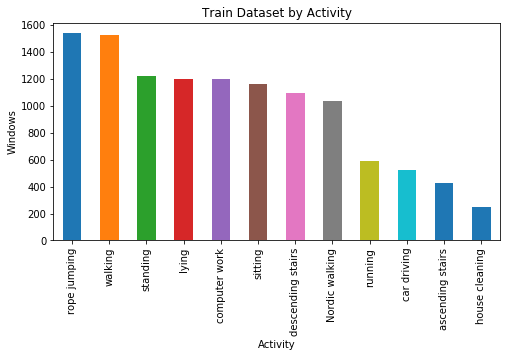

In [14]:
s = train_data_df.groupby('activity_id').count()['act_level']
s = s.rename("Activity Counts")
s.index = [activity_id[x] for x in soldier_acts]
print(('Train Dataset by Activity'))
display(s.sort_values(ascending =False))
ax = s.sort_values(ascending =False).plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('Windows')
_ = ax.set_xlabel('Activity')
_ = ax.set_title('Train Dataset by Activity')


Train Dataset by Activity Intensity Level


act_level
high      1366
low       5124
medium    5283
Name: Activity Level Counts, dtype: int64

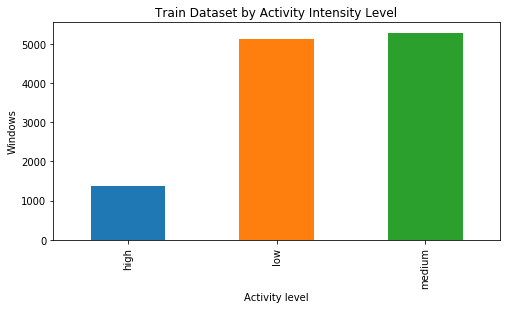

In [15]:
s = train_data_df.groupby('act_level').count()['activity_id']
s = s.rename("Activity Level Counts")
print(('Train Dataset by Activity Intensity Level'))
display(s)
ax = s.plot(kind='bar', figsize=(8,4))
_ = ax.set_ylabel('Windows')
_ = ax.set_xlabel('Activity level')
_ = ax.set_title('Train Dataset by Activity Intensity Level')


In [16]:
# MEAN HEART RATE BY ACTIVITY AND SUBJECT 

In [17]:
def plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=True, showannot=False):
    """Function used to plot heatmap using input dataframe"""
    mycmap = LinearSegmentedColormap.from_list('mycmap', ['lightgreen', 'tomato'])
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    _ = sns.heatmap(df, cmap = mycmap, yticklabels=yticks, xticklabels=xticks, square=True,\
                    linewidths=0.01, cbar=showcbar, annot=showannot,fmt='.1f')
    _ = ax.set_ylabel(ylabel)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_title(title)
    
def plot_series(df, feat, location, act, unit, pylim):
    plottitle = location + ' ' + feat + ' - ' + act
    plotx = location.lower() + '_' + feat.lower()[0:3] + '_x_mean'
    ploty = location.lower() + '_' + feat.lower()[0:3] + '_y_mean'
    plotz = location.lower() + '_' + feat.lower()[0:3] + '_z_mean'
    ax1 = df.plot(x=df.index,y=plotx, color='r', figsize=(12,5), ylim=pylim)
    _ = df.plot(x=df.index,y=ploty, color='g', ax=ax1)
    _ = df.plot(x=df.index,y=plotz, color='b', ax=ax1)
    _ = ax1.set_title(plottitle)
    _ = ax1.set_xlabel('window')
    _ = ax1.set_ylabel(unit)
    

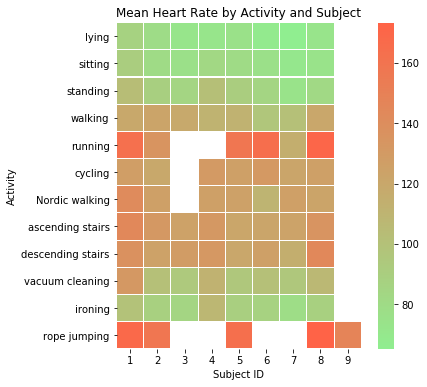

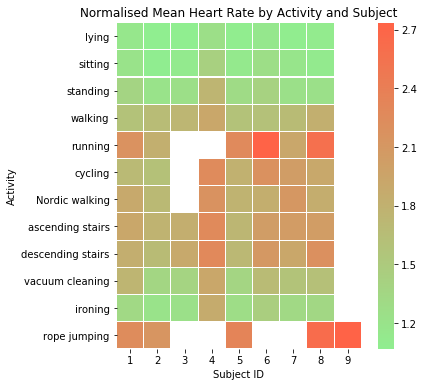

In [18]:
yticks = [y for x, y in activity_id.items() if x in protocol_acts]
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Activity'
xlabel = 'Subject ID'

title = 'Mean Heart Rate by Activity and Subject'
df = train_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hr_mean']].pivot(index='activity_id', columns='sub_id', values='hr_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Normalised Mean Heart Rate by Activity and Subject'
df = train_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hr_mean_normal']].pivot(index='activity_id', columns='sub_id', values='hr_mean_normal')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)


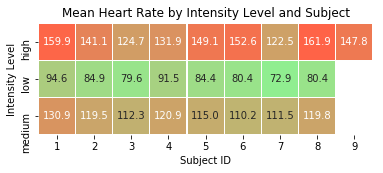

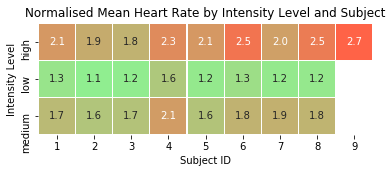

In [19]:
df = train_data_df.groupby(['act_level','sub_id'], as_index=False).mean() \
            [['act_level','sub_id','hr_mean']].pivot(index='act_level', columns='sub_id', values='hr_mean')
    
yticks = ['high','low','medium']
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Intensity Level'
xlabel = 'Subject ID'
title = 'Mean Heart Rate by Intensity Level and Subject'
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=False, showannot=True)

df = train_data_df.groupby(['act_level','sub_id'], as_index=False).mean() \
            [['act_level','sub_id','hr_mean_normal']].pivot(index='act_level', columns='sub_id', values='hr_mean_normal')
title = 'Normalised Mean Heart Rate by Intensity Level and Subject'
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks, showcbar=False, showannot=True)


In [20]:
# TEMPERATURE BY ACTIVITY AND SUBJECT 

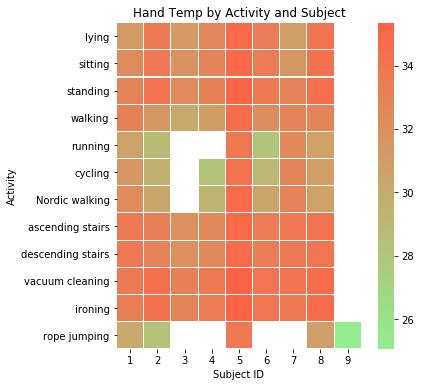

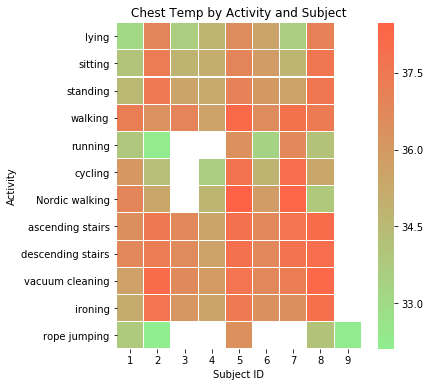

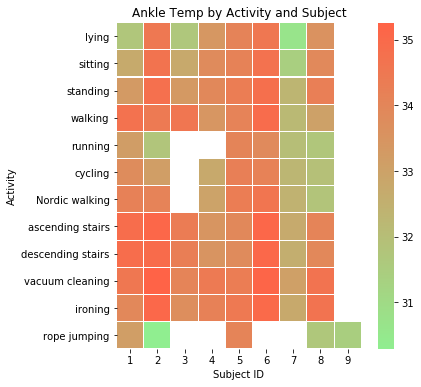

In [21]:
yticks = [y for x, y in activity_id.items() if x in protocol_acts]
xticks = [1,2,3,4,5,6,7,8,9]
ylabel = 'Activity'
xlabel = 'Subject ID'

title = 'Hand Temp by Activity and Subject'
df = train_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','hand_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='hand_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Chest Temp by Activity and Subject'
df = train_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','chest_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='chest_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)

title = 'Ankle Temp by Activity and Subject'
df = train_data_df.groupby(['activity_id','sub_id'], as_index=False).mean() \
            [['activity_id','sub_id','ankle_tmp_mean']].pivot(index='activity_id', columns='sub_id', values='ankle_tmp_mean')
plot_heatmap(df, title, xlabel, ylabel, xticks, yticks)


In [22]:
# IMPORT SKLEARN MODULES

from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.utils.multiclass import unique_labels

import time

In [78]:
#Read features from csv files
train_data_df = pd.read_csv("train_data.csv", header=0)
test_data_df = pd.read_csv("test_data.csv", header=0)

In [23]:
# DEFINE CUSTOM CONFUSION MATRIX

def confusion_matrix(predict_labels, real_labels, cats, title):

    pred_results = {}
    base_dict = {}
    
    #If cats parameter is False, the matrix is created with activity data from protocol activities (or soldier_acts)
    if not cats:
        for i in protocol_acts:
            base_dict[i]=0
        for i in protocol_acts:
            pred_results[i] = base_dict.copy()
    else:
        for i in cats:
            base_dict[i]=0
        for i in cats:
            pred_results[i] = base_dict.copy()
    
    #Dictionary is created counting real values for predicted labels
    for pl,tl in list(zip(predict_labels,  real_labels)):
        pred_results[pl][tl]+=1

    pred_results_df = pd.DataFrame(pred_results)
    if not cats:
        pred_results_df.columns=[activity_id[x] for x in protocol_acts]
        pred_results_df.index = [activity_id[x] for x in protocol_acts]
    
    #Accuracy, precision, recall and f-score are calculated using sklearn library
    precision = precision_score(real_labels, predict_labels, average='macro')
    recall = recall_score(real_labels, predict_labels, average='macro')
    accuracy = accuracy_score(real_labels, predict_labels)
    fscore = f1_score(real_labels, predict_labels, average='macro')
    
    #Display results
    print((title))
    display((pred_results_df))
    print(('Accuracy: ' + str(accuracy)))
    print(('Precision: ' + str(precision)))
    print(('Recall: ' + str(recall)))
    print(('F-score: ' + str(fscore)))


In [24]:
# ACTIVITY PREDICTION MODELS

In [25]:
DT_Classifier1 = tree.DecisionTreeClassifier()

features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal']
label_col = 'act_level'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
DT_Classifier1.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

start = time.time()
predict_labels = DT_Classifier1.predict(test_data)
end = time.time()

elapsed = end - start
print("PredictionDuration (msecs):", elapsed)
print("TimeDivision (msecs):", 1000*elapsed/len(test_data))

confusion_matrix(predict_labels, real_labels, ['low','medium','high'], "Confusion Matrix for Decision Tree using HR features only")

PredictionDuration (msecs): 0.00648808479309082
TimeDivision (msecs): 0.0012857877116707929
Confusion Matrix for Decision Tree using HR features only


,low,medium,high
high,8,162,446
low,2020,128,3
medium,135,2010,134


Accuracy: 0.8870392390011891
Precision: 0.8576032460539099
Recall: 0.8483632807994224
F-score: 0.8527866992800566


In [26]:
#SVM_Classifier = svm.SVC(kernel='linear', C=0.25) This is suboptimal!
SVM_Classifier1 = svm.SVC(gamma='auto')

features_used = ['hr_mean','hr_mean_normal','hr_std','hr_std_normal']
label_col = 'act_level'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
SVM_Classifier1.fit(train_data, train_labels)

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

start = time.time()
predict_labels = SVM_Classifier1.predict(test_data)
end = time.time()

elapsed = end - start
print("PredictionDuration (msecs):", elapsed)
print("TimeDivision (msecs):", 1000*elapsed/len(test_data))

confusion_matrix(predict_labels, real_labels, ['low','medium','high'], "Confusion Matrix for SVM using HR features only")

PredictionDuration (msecs): 0.35304856300354004
TimeDivision (msecs): 0.0699660251691518
Confusion Matrix for SVM using HR features only


,low,medium,high
high,5,152,459
low,1902,247,2
medium,141,2049,89


Accuracy: 0.8739595719381689
Precision: 0.8667553986556743
Recall: 0.8428161005915232
F-score: 0.8533905489211676


In [27]:
# ACCELEROMETER PREDICTION MODEL COMPARISONS

In [28]:
DT_Classifier2 = tree.DecisionTreeClassifier()

features_used = ['hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'hand_acc_xy_cor','hand_acc_yz_cor','hand_acc_xz_cor','chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor'
                ]
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
DT_Classifier2.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

start = time.time()
predict_labels = DT_Classifier2.predict(test_data)
end = time.time()

elapsed = end - start
print("PredictionDuration (msecs):", elapsed)
print("TimeDivision (msecs):", 1000*elapsed/len(test_data))

confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Accelerometer features")


PredictionDuration (msecs): 0.0
TimeDivision (msecs): 0.0
Confusion Matrix for Decision Tree using Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,485,3,0,0,0,0,5,0,0,0,0
standing,0,3,474,0,0,2,0,3,1,0,0,0
walking,0,0,0,659,0,0,3,0,0,0,4,2
running,0,0,0,0,242,0,0,0,0,0,0,0
cycling,0,0,0,0,0,424,0,0,11,0,2,0
Nordic walking,0,0,0,0,0,0,512,0,0,0,0,1
ironing,0,0,0,4,0,0,1,0,0,0,248,4
vacuum cleaning,0,0,0,2,0,0,0,0,1,0,4,196
rope jumping,0,3,2,0,0,9,0,11,433,0,0,0


Accuracy: 0.9782005548949663
Precision: 0.9783053941752535
Recall: 0.978104064864297
F-score: 0.9781856491445576


In [29]:
SVM_Classifier2 = svm.SVC(gamma='auto')

features_used = ['hand_acc_x_mean','hand_acc_x_std','hand_acc_y_mean','hand_acc_y_std','hand_acc_z_mean','hand_acc_z_std',
                    'chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'hand_acc_xy_cor','hand_acc_yz_cor','hand_acc_xz_cor','chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor'
                ]
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
SVM_Classifier2.fit(train_data, train_labels)

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

start = time.time()
predict_labels = SVM_Classifier2.predict(test_data)
end = time.time()

elapsed = end - start
print("PredictionDuration (msecs):", elapsed)
print("TimeDivision (msecs):", 1000*elapsed/len(test_data))

confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for SVM using Accelerometer features")



PredictionDuration (msecs): 0.36504364013671875
TimeDivision (msecs): 0.0723431708554734
Confusion Matrix for SVM using Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,492,0,0,0,0,0,1,0,0,0,0
standing,0,2,478,0,0,0,0,3,0,0,0,0
walking,0,0,0,668,0,0,0,0,0,0,0,0
running,0,0,0,0,241,0,0,0,1,0,0,0
cycling,0,0,0,0,0,437,0,0,0,0,0,0
Nordic walking,0,0,0,0,0,0,513,0,0,0,0,0
ironing,0,0,0,0,0,0,0,0,0,0,257,0
vacuum cleaning,0,0,0,0,0,0,0,0,0,0,0,203
rope jumping,0,0,0,0,0,1,0,2,455,0,0,0


Accuracy: 0.9980182322631788
Precision: 0.9985274156718051
Recall: 0.9980780988179
F-score: 0.998297814487803


In [30]:
DT_Classifier3 = tree.DecisionTreeClassifier()

features_used = ['ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
DT_Classifier3.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

start = time.time()
predict_labels = DT_Classifier3.predict(test_data)
end = time.time()

elapsed = end - start
print("PredictionDuration (msecs):", elapsed)
print("TimeDivision (msecs):", 1000*elapsed/len(test_data))

confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Ankle Accelerometer features")


PredictionDuration (msecs): 0.000997304916381836
TimeDivision (msecs): 0.00019764267070587315
Confusion Matrix for Decision Tree using Ankle Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,457,8,0,0,2,0,15,11,0,0,0
standing,0,19,383,0,0,0,0,63,18,0,0,0
walking,0,0,0,625,0,0,39,0,0,0,2,2
running,0,0,0,0,241,0,0,0,0,0,0,1
cycling,0,1,1,0,0,425,0,0,6,1,3,0
Nordic walking,0,0,0,22,0,0,489,0,0,0,1,1
ironing,0,0,0,0,0,0,0,0,4,2,247,4
vacuum cleaning,0,0,0,4,2,0,0,0,1,1,6,189
rope jumping,0,4,13,2,0,1,0,49,387,0,1,1


Accuracy: 0.9082441537851764
Precision: 0.9191911703093552
Recall: 0.9192822867710991
F-score: 0.9190785989102759


In [31]:
DT_Classifier4 = tree.DecisionTreeClassifier()

features_used = ['chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
DT_Classifier4.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

start = time.time()
predict_labels = DT_Classifier4.predict(test_data)
end = time.time()

elapsed = end - start
print("PredictionDuration (msecs):", elapsed)
print("TimeDivision (msecs):", 1000*elapsed/len(test_data))

confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for Decision Tree using Chest Accelerometer features")


PredictionDuration (msecs): 0.0
TimeDivision (msecs): 0.0
Confusion Matrix for Decision Tree using Chest Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,436,39,0,0,4,0,10,4,0,0,0
standing,0,48,416,0,0,2,0,17,0,0,0,0
walking,0,0,0,627,0,1,22,0,0,0,12,6
running,0,0,0,0,238,0,0,0,0,3,0,1
cycling,0,4,0,0,0,424,0,1,7,0,1,0
Nordic walking,0,0,0,16,0,0,485,0,0,0,7,5
ironing,0,0,0,11,0,2,13,0,0,0,228,3
vacuum cleaning,0,0,0,2,0,0,2,0,0,0,8,191
rope jumping,0,6,1,1,0,7,1,19,421,0,2,0


Accuracy: 0.9294490685691637
Precision: 0.9321697912348329
Recall: 0.9337540676505264
F-score: 0.9329188156015508


In [32]:
SVM_Classifier3 = svm.SVC(gamma='auto')

features_used = ['ankle_acc_x_mean','ankle_acc_x_std','ankle_acc_y_mean','ankle_acc_y_std','ankle_acc_z_mean','ankle_acc_z_std',
                    'ankle_acc_xy_cor','ankle_acc_yz_cor','ankle_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
SVM_Classifier3.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

start = time.time()
predict_labels = SVM_Classifier3.predict(test_data)
end = time.time()

elapsed = end - start
print("PredictionDuration (msecs):", elapsed)
print("TimeDivision (msecs):", 1000*elapsed/len(test_data))

confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for SVM using Ankle Accelerometer features")

PredictionDuration (msecs): 0.596402645111084
TimeDivision (msecs): 0.11819315202359967
Confusion Matrix for SVM using Ankle Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,460,14,0,0,0,0,10,9,0,0,0
standing,0,31,351,0,0,0,0,82,19,0,0,0
walking,0,0,0,635,0,0,33,0,0,0,0,0
running,0,0,0,0,241,0,0,0,0,1,0,0
cycling,0,0,0,0,0,431,0,0,6,0,0,0
Nordic walking,0,0,0,51,0,0,462,0,0,0,0,0
ironing,0,0,0,2,0,0,0,0,0,2,249,4
vacuum cleaning,0,0,0,0,0,0,0,0,0,0,2,201
rope jumping,0,0,3,2,0,3,0,41,407,0,0,2


Accuracy: 0.9064605628220372
Precision: 0.9229050352303858
Recall: 0.924607327114615
F-score: 0.9235355870463886


In [33]:
SVM_Classifier4 = svm.SVC(gamma='auto')

features_used = ['chest_acc_x_mean','chest_acc_x_std','chest_acc_y_mean','chest_acc_y_std','chest_acc_z_mean','chest_acc_z_std',
                    'chest_acc_xy_cor','chest_acc_yz_cor','chest_acc_xz_cor']
label_col = 'activity_id'

train_data = np.array(train_data_df.loc[:, features_used])
train_labels = np.array(train_data_df.loc[:, label_col])
SVM_Classifier4.fit(train_data, train_labels) 

test_data = np.array(test_data_df.loc[:, features_used])
real_labels = np.array(test_data_df.loc[:, label_col])

start = time.time()
predict_labels = SVM_Classifier4.predict(test_data)
end = time.time()

elapsed = end - start
print("PredictionDuration (msecs):", elapsed)
print("TimeDivision (msecs):", 1000*elapsed/len(test_data))

confusion_matrix(predict_labels, real_labels, False, "Confusion Matrix for SVM using Chest Accelerometer features")


PredictionDuration (msecs): 0.5255899429321289
TimeDivision (msecs): 0.10415971917006121
Confusion Matrix for SVM using Chest Accelerometer features


,lying,sitting,standing,walking,running,cycling,Nordic walking,ironing,vacuum cleaning,rope jumping,ascending stairs,descending stairs
lying,525,0,0,0,0,0,0,0,0,0,0,0
sitting,0,444,39,0,0,0,0,7,3,0,0,0
standing,0,88,378,0,0,1,0,16,0,0,0,0
walking,0,0,0,640,0,0,16,0,0,0,12,0
running,0,0,0,0,242,0,0,0,0,0,0,0
cycling,0,4,0,0,0,428,0,0,5,0,0,0
Nordic walking,0,0,0,27,0,0,485,0,0,0,1,0
ironing,0,0,0,9,0,0,5,0,0,0,237,6
vacuum cleaning,0,0,0,4,0,0,2,0,0,0,0,197
rope jumping,0,0,0,2,0,3,0,27,426,0,0,0


Accuracy: 0.9371779627427665
Precision: 0.9462701521617842
Recall: 0.9421928687316096
F-score: 0.9438802278867149


In [90]:
# SEPARATE PARTICIPANTS


In [34]:
#Isolate subjects 1,2,5, and 8
drop_sub_list = [3,4,6,7,9]
#Isolate activities 1,2,3,4,5,7,10,11,12,13,19,24
drop_act_list = [6,8,9,16,17,18,20]

In [35]:
drop_index_2 = []

drop_index_2 += list(pamap2.index[(pamap2['sub_id']==1) & (pamap2['activity_id'].isin([drop_act_list]))])
drop_index_2 += list(pamap2.index[(pamap2['sub_id']==2) & (pamap2['activity_id'].isin([drop_act_list]))])
drop_index_2 += list(pamap2.index[(pamap2['sub_id']==3)])
drop_index_2 += list(pamap2.index[(pamap2['sub_id']==4)])
drop_index_2 += list(pamap2.index[(pamap2['sub_id']==5) & (pamap2['activity_id'].isin([drop_act_list]))])
drop_index_2 += list(pamap2.index[(pamap2['sub_id']==6)])
drop_index_2 += list(pamap2.index[(pamap2['sub_id']==7)])
drop_index_2 += list(pamap2.index[(pamap2['sub_id']==8) & (pamap2['activity_id'].isin([drop_act_list]))])
drop_index_2 += list(pamap2.index[(pamap2['sub_id']==9)])




In [36]:
sim_data_df = pamap2.drop(drop_index_2)

In [37]:
sim_data_df.head(100)

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_level,act_block
3928,47.66,1,103.0,30.5,-7.76319,-6.59656,0.831271,-7.59876,-6.81413,0.952719,-0.023345,-0.094827,0.200758,11.67170,53.3611,-20.7827,1.0,0.0,0.0,0.0,32.3125,-1.428290,4.59099,-9.911060,-1.667120,4.60909,-9.668380,-1.696650,0.073002,0.284169,44.5122,-11.2486,51.24430,1.0,0.0,0.0,0.0,30.875,9.356030,1.448820,-3.44087,9.482080,1.661260,-3.42233,0.100157,-0.328539,0.148857,-74.7494,-45.4312,-41.3917,1.0,0.0,0.0,0.0,1,low,1
3929,47.67,1,103.0,30.5,-7.96283,-6.78714,0.559511,-7.81101,-6.84291,0.832193,0.119344,-0.173491,0.228492,10.79910,53.7261,-19.8429,1.0,0.0,0.0,0.0,32.3125,-1.302410,4.63088,-9.521700,-1.621060,4.68434,-9.592870,-1.778710,0.069577,0.317669,44.0021,-12.7925,50.86680,1.0,0.0,0.0,0.0,30.875,9.457720,1.108960,-3.74644,9.407290,1.449600,-3.33044,0.022160,-0.316792,0.150338,-76.0839,-46.1565,-41.3886,1.0,0.0,0.0,0.0,1,low,1
3930,47.68,1,103.0,30.5,-7.56159,-6.94546,0.181182,-7.78390,-6.97924,0.605953,0.293628,-0.223687,0.237504,10.24440,53.4288,-19.6083,1.0,0.0,0.0,0.0,32.3125,-1.109250,4.74376,-9.441130,-1.484310,4.77441,-9.457420,-1.757580,0.041567,0.325210,44.5969,-13.3610,49.77180,1.0,0.0,0.0,0.0,30.875,8.735770,0.508215,-4.02024,9.136370,0.920061,-3.41811,0.000155,-0.259867,0.156328,-75.4083,-45.9693,-40.6494,1.0,0.0,0.0,0.0,1,low,1
3931,47.69,1,103.0,30.5,-7.27130,-7.14018,-0.121712,-7.59227,-7.11690,0.228539,0.516965,-0.241007,0.224821,9.80950,52.9010,-18.9146,1.0,0.0,0.0,0.0,32.3125,-1.178960,5.04652,-9.249770,-1.437260,4.86454,-9.230760,-1.841740,-0.005494,0.366242,44.5062,-13.9122,49.27940,1.0,0.0,0.0,0.0,30.875,9.520780,0.959822,-4.13076,8.820060,0.798751,-3.61280,-0.003502,-0.218614,0.199243,-76.1764,-46.5085,-39.5349,1.0,0.0,0.0,0.0,1,low,1
3932,47.70,1,103.0,30.5,-7.19573,-6.95140,-0.159704,-7.24956,-7.30087,-0.058323,0.646473,-0.272410,0.216307,9.98846,52.2646,-21.0066,1.0,0.0,0.0,0.0,32.3125,-1.287090,5.23644,-9.058740,-1.480140,5.07573,-9.078760,-1.853510,-0.055315,0.391737,44.3054,-14.8072,50.13320,1.0,0.0,0.0,0.0,30.875,9.255100,0.886508,-4.24880,9.344720,1.101010,-3.90413,-0.015711,-0.279977,0.195484,-76.4170,-45.6111,-40.0185,1.0,0.0,0.0,0.0,1,low,1
3933,47.71,1,103.0,30.5,-7.34474,-7.02544,-0.084712,-7.21878,-7.19540,-0.088787,0.756132,-0.291966,0.195382,9.54110,51.5274,-20.8937,1.0,0.0,0.0,0.0,32.3125,-1.099990,5.64900,-9.211580,-1.447590,5.37739,-8.987400,-1.869250,-0.077624,0.466869,45.1543,-16.0502,48.55090,1.0,0.0,0.0,0.0,30.875,9.036870,0.619902,-3.97926,8.983960,0.949629,-3.94713,0.009023,-0.256057,0.232798,-76.3084,-45.7171,-40.6394,1.0,0.0,0.0,0.0,1,low,1
3934,47.72,1,103.0,30.5,-7.67549,-6.83110,0.140603,-7.47258,-7.11786,0.122713,0.845222,-0.310498,0.164195,9.64515,52.3992,-21.4642,1.0,0.0,0.0,0.0,32.3125,-1.163040,5.87801,-8.787530,-1.354790,5.70913,-8.911440,-1.934730,-0.075978,0.495424,44.9454,-16.6042,48.79210,1.0,0.0,0.0,0.0,30.875,9.521000,0.579494,-4.05122,9.059700,0.738100,-3.78037,-0.018201,-0.281838,0.237998,-76.0727,-45.6361,-39.0313,1.0,0.0,0.0,0.0,1,low,1
3935,47.73,1,103.0,30.5,-7.79208,-6.52806,-0.016116,-7.59137,-6.87540,0.092102,0.985834,-0.254816,0.122707,10.18830,51.1769,-21.9465,1.0,0.0,0.0,0.0,32.3125,-1.088800,5.99021,-8.864000,-1.292540,5.96546,-8.835510,-1.972350,-0.149502,0.515534,43.5176,-17.7776,47.91080,1.0,0.0,0.0,0.0,3

In [38]:
sim_data_df.describe()

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_block
count,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,9.358500e+05,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,9.358500e+05,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000,935850.000000
mean,1846.510767,8.082059,111.709609,33.193978,-4.725613,2.973656,3.519211,-4.652795,2.981518,3.717144,0.001720,0.059316,-0.001243,19.381943,-13.083307,-24.723957,6.109247e-01,-0.019482,-0.091639,-0.089723,36.447719,0.388660,7.971980,-2.040919,0.265005,7.964801,-1.712749,0.004284,0.011667,-0.019209,3.438636,-32.117341,6.420171,5.765235e-01,-0.345248,0.087034,0.071409,33.871341,9.439599,-0.227418,-2.817949,9.401429,-0.129704,-2.403255,0.008191,-0.030215,0.005170,-34.816098,2.270104,17.194612,0.468957,0.018735,0.277205,-0.025110,4.047316,46.866987
std,1186.500485,6.320210,27.453217,1.740021,6.379458,7.454869,3.954926,6.408001,7.439010,3.965750,1.415034,0.986534,1.788360,26.666000,26.682128,21.598924,3.188223e-01,0.336351,0.320962,0.540471,1.590896,1.785721,5.478727,5.036667,1.776722,5.391711,5.053180,0.517629,0.569776,0.359705,18.502659,19.268622,23.646694,3.305793e-01,0.308612,0.467371,0.335843,1.028100,7.123045,8.251369,4.097997,6.614655,7.557352,3.631855,1.144527,0.728381,2.194679,19.353756,23.707717,20.242070,0.342750,0.526356,0.347553,0.432314,2.720629,35.698737
min,47.660000,1.000000,66.000000,28.312500,-106.527000,-104.301000,-55.963700,-61.214700,-61.841700,-47.051500,-27.804400,-13.390400,-14.264700,-103.941000,-200.043000,-164.937000,1.364250e-07,-0.998944,-0.974916,-0.999186,31.937500,-39.203400,-46.924600,-80.166800,-34.204000,-48.257200,-61.804100,-12.525100,-5.068580,-4.404200,-70.062700,-122.480000,-66.684700,7.710670e-08,-0.995636,-0.999635,-0.788081,30.187500,-155.068000,-157.443000,-157.245000,-61.142000,-61.902600,-62.192500,-23.995000,-18.126900,-14.019600,-172.865000,-137.908000,-102.716000,0.000002,-0.956876,-0.860089,-0.915269,1.000000,1.000000
25%,756.090000,3.000000,89.000000,31.812500,-8.732897,-0.295289,0.986845,-8.607630,-0.328176,1.194150,-0.420697,-0.245296,-0.535132,0.635802,-29.809175,-39.533375,3.395187e-01,-0.236880,-0.326965,-0.592077,35.375000,-0.456009,5.089190,-4.920212,-0.554064,5.063065,-4.659517,-0.136833,-0.152925,-0.156033,-8.310920,-41.777250,-8.748803,2.977222e-01,-0.615236,-0.141898,-0.056799,33.437500,7.527603,-2.603670,-4.053510,7.570560,-2.589010,-3.614200,-0.241451,-0.135513,-0.527801,-44.129650,-14.765400,2.652872,0.184781,-0.465328,0.000000,-0.438537,2.000000,15.000000
50%,1683.830000,6.000000,112.000000,33.812500,-5.015160,3.445460,3.425310,-4.917290,3.477310,3.668645,-0.005815,0.006656,-0.006475,22.334250,-14.884500,-24.611500,6.257995e-01,0.000000,0.000000,0.000000,37.000000

In [ ]:
#Save the sim dataframe to a local file
sim_data_df.to_csv("sim_data.csv", index=False)

In [39]:
#Isolate subjects 1,2,5, and 8
drop_sub_list1 = [2,5,8]
drop_sub_list2 = [1,5,8]
drop_sub_list5 = [1,2,8]
drop_sub_list8 = [1,2,5]


In [40]:
drop_index_1 = []
drop_index_1 += list(sim_data_df.index[(sim_data_df['sub_id']==2)])
drop_index_1 += list(sim_data_df.index[(sim_data_df['sub_id']==5)])
drop_index_1 += list(sim_data_df.index[(sim_data_df['sub_id']==8)])
sim1_data_df = sim_data_df.drop(drop_index_1)

drop_index_2 = []
drop_index_2 += list(sim_data_df.index[(sim_data_df['sub_id']==1)])
drop_index_2 += list(sim_data_df.index[(sim_data_df['sub_id']==5)])
drop_index_2 += list(sim_data_df.index[(sim_data_df['sub_id']==8)])
sim2_data_df = sim_data_df.drop(drop_index_2)

drop_index_5 = []
drop_index_5 += list(sim_data_df.index[(sim_data_df['sub_id']==1)])
drop_index_5 += list(sim_data_df.index[(sim_data_df['sub_id']==2)])
drop_index_5 += list(sim_data_df.index[(sim_data_df['sub_id']==8)])
sim5_data_df = sim_data_df.drop(drop_index_5)

drop_index_8 = []
drop_index_8 += list(sim_data_df.index[(sim_data_df['sub_id']==1)])
drop_index_8 += list(sim_data_df.index[(sim_data_df['sub_id']==2)])
drop_index_8 += list(sim_data_df.index[(sim_data_df['sub_id']==5)])
sim8_data_df = sim_data_df.drop(drop_index_8)

In [41]:
sim5_data_df.head(100)

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_level,act_block
1416706,114.50,1,95.0,34.6875,-7.96582,5.37034,2.32736,-7.82751,5.52767,2.61720,-0.276009,-0.357206,0.518213,34.61670,12.7939,-26.3586,0.534829,-0.591169,-0.128537,0.589878,36.3125,0.960413,8.66843,-1.633480,1.071700,8.71161,-1.225050,-1.206040,0.235857,-0.109803,25.2001,-27.8688,29.65380,0.580759,-0.732944,-0.261711,-0.238786,34.0,9.586920,-1.150940,-1.415720,9.745200,-1.058670,-1.371730,-0.252434,0.241800,0.031966,-44.941100,-44.376200,4.42197,0.456689,-0.513404,0.592052,-0.421101,5,low,52
1416707,114.51,1,95.0,34.6875,-7.97197,5.44454,2.13458,-7.79737,5.52745,2.61717,-0.232391,-0.360211,0.502809,35.10690,13.1402,-26.0992,0.537964,-0.589927,-0.127426,0.588510,36.3125,0.741820,8.59617,-1.288720,0.785960,8.59132,-1.087660,-1.160520,0.151540,-0.145898,24.9507,-28.2464,29.51320,0.585003,-0.729191,-0.261267,-0.240399,34.0,9.960080,-1.152990,-1.450470,9.776380,-1.028080,-1.099560,-0.235796,0.279717,0.059937,-44.807500,-45.028600,3.71404,0.458108,-0.511807,0.591889,-0.421732,5,low,52
1416708,114.52,1,95.0,34.6875,-7.88837,5.44597,2.36675,-7.79763,5.46707,2.64750,-0.277735,-0.359196,0.447936,34.36350,13.0556,-26.2284,0.540914,-0.588491,-0.126374,0.587469,36.3125,0.403961,8.82419,-1.140690,0.531642,8.68227,-0.949852,-1.123820,0.115406,-0.209401,25.3577,-28.3892,28.38890,0.589398,-0.725504,-0.260757,-0.241372,34.0,9.965010,-1.686790,-1.176980,9.807420,-1.284880,-0.841597,-0.291775,0.360522,0.129080,-45.463000,-44.353100,3.42728,0.459757,-0.509644,0.591794,-0.422689,5,low,52
1416709,114.53,1,95.0,34.6875,-8.04327,5.29471,2.28797,-7.85829,5.45238,2.61740,-0.296949,-0.352221,0.410308,34.99040,12.6499,-26.2272,0.543725,-0.587065,-0.125603,0.586465,36.3125,0.212643,8.97514,-1.183370,0.276509,8.75828,-0.932979,-1.124310,0.109246,-0.226302,25.2419,-29.5459,28.67660,0.593728,-0.721746,-0.260409,-0.242398,34.0,9.637230,-2.485860,-0.712303,9.733350,-1.859290,-0.551786,-0.297836,0.405987,0.177543,-45.461400,-44.870600,2.57690,0.461403,-0.507088,0.591775,-0.423996,5,low,52
1416710,114.54,1,95.0,34.6875,-7.99906,5.25816,2.48119,-7.87362,5.40720,2.63261,-0.289824,-0.371767,0.364648,34.37060,13.1787,-27.2790,0.546166,-0.585494,-0.124457,0.586012,36.3125,0.244393,9.16174,-1.415730,0.081457,8.84930,-0.946650,-1.086950,0.083564,-0.281000,25.1091,-28.5085,27.96480,0.597989,-0.718051,-0.260211,-0.243111,34.0,9.643060,-3.057950,-0.399976,9.674630,-2.615090,-0.170663,-0.322114,0.517515,0.261237,-45.708300,-45.115000,2.85998,0.462992,-0.504050,0.591757,-0.425905,5,low,52
1416711,114.55,1,95.0,34.6875,-8.10922,5.33558,2.55625,-7.84335,5.42208,2.63255,-0.283738,-0.365616,0.311448,34.25310,12.1927,-26.4854,0.548435,-0.583975,-0.123600,0.585590,36.3125,0.249068,9.20043,-1.260890,0.052441,9.04562,-0.976130,-1.133790,0.115330,-0.310928,25.2439,-29.6749,28.67740,0.602251,-0.714105,-0.260313,-0.244097,34.0,10.042200,-3.132970,-0.819902,9.749740,-3.053660,-0.139380,-0.196676,0.625665,0.305120,-45.332100,-44.876700,2.71919,0.464353,-0.500952,0.591379,-0.428596,5,low,52
1416712,114.56,1,95.0,34.6875,-8.03418,5.44848,2.51851,-7.87260,5.48274,2.67775,-0.311906,-0.405024,0.295603,33.87560,12.4611,-26.3551,0.550788,-0.582248,-0.122787,0.585272,36.3125,0.526762,9.42785,-0.908106,0.174092,9.19619,-0.915976,-1.090430,0.166478,-0.355025,2

In [42]:
sim1_data_df.describe()

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_block
count,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.0,221957.0,221957.0,221957.0,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.0,221957.0,221957.0,221957.0,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.000000,221957.0,221957.0,221957.0,221957.0,221957.0,221957.000000
mean,1699.051348,8.154697,121.730268,32.401487,-4.424966,5.659667,3.725739,-4.391085,5.696279,3.883992,0.065622,0.073215,0.008164,19.753508,-25.619365,-28.007145,1.0,0.0,0.0,0.0,35.204246,0.450906,7.685566,-2.485578,0.290628,7.703565,-2.217149,0.002397,0.010516,-0.024410,-0.437736,-43.837913,7.862628,1.0,0.0,0.0,0.0,33.636181,9.006896,0.711736,-2.819743,8.964577,0.841027,-2.408372,0.006244,0.010840,0.017094,-49.225869,-4.348407,15.312717,1.0,0.0,0.0,0.0,1.0,7.000743
std,1110.482313,6.521879,26.698270,1.107776,6.878347,6.245721,3.876182,6.910817,6.284296,3.862229,1.169066,0.984018,2.009609,35.364371,30.712059,29.730833,0.0,0.0,0.0,0.0,1.383132,2.021200,6.020877,5.100072,2.005076,5.972789,5.075366,0.568376,0.616853,0.358515,25.933603,25.336479,33.827315,0.0,0.0,0.0,0.0,0.978390,7.166079,8.842256,4.314677,6.724130,7.822903,3.927798,1.049921,0.664618,2.059079,26.096351,32.448359,29.799959,0.0,0.0,0.0,0.0,0.0,4.408053
min,47.660000,1.000000,78.000000,30.187500,-57.534900,-49.201600,-23.881700,-56.984200,-42.797200,-20.588700,-10.739900,-6.957370,-10.608800,-75.282900,-160.787000,-164.937000,1.0,0.0,0.0,0.0,32.312500,-19.939900,-25.955900,-53.401900,-17.606700,-25.289400,-48.660900,-4.891900,-4.672250,-2.642760,-70.062700,-122.480000,-66.684700,1.0,0.0,0.0,0.0,30.875000,-49.507200,-155.356000,-133.640000,-46.950900,-61.898600,-48.112900,-11.688700,-7.807450,-11.619400,-172.865000,-137.908000,-102.716000,1.0,0.0,0.0,0.0,1.0,1.000000
25%,642.550000,3.000000,99.000000,31.562500,-8.368880,2.885760,1.394140,-8.272540,2.936010,1.584730,-0.360286,-0.242351,-0.567579,-8.828690,-47.173500,-52.293200,1.0,0.0,0.0,0.0,33.937500,-0.354190,4.458690,-5.655030,-0.483148,4.408810,-5.449740,-0.151138,-0.130862,-0.169045,-22.151800,-60.542900,-12.599800,1.0,0.0,0.0,0.0,33.125000,6.137910,-2.443280,-4.668430,6.157340,-2.416730,-4.289830,-0.296523,-0.067581,-0.579388,-63.821600,-29.004700,-5.980360,1.0,0.0,0.0,0.0,1.0,3.000000
50%,1581.990000,6.000000,122.000000,32.562500,-4.405530,4.989210,3.811260,-4.308340,5.037710,4.013070,0.001881,0.009573,-0.006494,21.524800,-29.488600,-29.717900,1.0,0.0,0.0,0.0,35.187500,0.515276,8.390080,-2.201680,0.360034,8.352710,-1.941560,-0.002368,-0.002129,-0.017399,-0.870249,-54.513300,14.676200,1.0,0.0,0.0,0.0,33.812500,9.427980,0.407516,-2.339650,9.444660,0.572816,-1.894060,-0.001898,0.006304,-0.005282,-52.700200,-6.717520,16.635800,1.0,0.0,0.0,0.0,1.0,6.000000
75%,2695.400000,13.000000,138.000000,33.312500,0.503694,7.418660,6.370040,0.477977,7.478560,6.642920,0.415033,0.327098,0.50

In [43]:
sim2_data_df.describe()

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_block
count,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,2.353490e+05,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.000000,235349.0,235349.000000
mean,2051.972938,8.311231,108.769238,32.344574,-5.139241,4.807655,3.193222,-5.090431,4.831000,3.346028,0.057215,0.044792,-0.002372,18.897359,-17.725555,-23.031672,0.465670,-0.064950,-0.189790,-0.070914,36.344124,0.234692,7.421462,-4.206215,0.100001,7.407255,-3.925986,0.008114,-0.011088,-0.000098,3.751415,-24.388016,12.944548,3.382775e-01,-0.465188,0.205114,0.156393,34.264525,9.633150,-0.940650,-1.634103,9.615802,-0.855137,-1.192552,-0.039409,-0.062561,0.002226,-28.779129,1.104468,17.086289,0.273066,-0.020632,0.353596,-0.098787,2.0,21.036023
std,1339.367148,6.443979,23.796616,2.027235,5.923128,4.184723,4.289030,5.979163,4.200225,4.335461,1.646941,1.122422,1.861245,19.072391,16.808833,19.421709,0.297195,0.328762,0.361899,0.640619,1.666244,1.553229,4.197983,5.081042,1.546483,4.203212,5.126569,0.605363,0.536586,0.452327,14.526652,12.311825,18.203471,2.469309e-01,0.299930,0.593770,0.314873,1.176197,6.350077,7.603155,3.655453,6.096329,6.793032,3.232920,1.167699,0.688220,2.078033,13.045573,16.836059,16.966255,0.218197,0.612107,0.283827,0.535997,0.0,4.182708
min,65.200000,1.000000,74.000000,28.312500,-70.948400,-50.029900,-32.417600,-57.608700,-55.405800,-32.574000,-14.694800,-10.822800,-8.537920,-42.342800,-149.484000,-151.076000,0.000002,-0.955671,-0.959419,-0.998322,31.937500,-19.193700,-11.813200,-57.497400,-10.944800,-11.823700,-58.026500,-6.596030,-3.556020,-4.404200,-50.777400,-59.918800,-28.510600,7.710670e-08,-0.995474,-0.998015,-0.715393,30.187500,-52.498400,-155.024000,-125.071000,-43.623200,-61.902600,-47.923900,-9.460560,-13.040100,-11.746300,-103.775000,-52.192200,-70.650100,0.000002,-0.956876,-0.693213,-0.915269,2.0,15.000000
25%,776.500000,3.000000,88.000000,30.437500,-8.888290,2.563270,0.512886,-8.823360,2.566200,0.641349,-0.363116,-0.264281,-0.686099,6.269980,-27.425700,-37.753500,0.182050,-0.307283,-0.465227,-0.661158,35.437500,-0.717992,4.268860,-6.802750,-0.833462,4.289830,-6.533490,-0.152932,-0.168587,-0.161486,-7.217410,-33.235100,4.557550,1.484920e-01,-0.727882,-0.388666,-0.098375,34.187500,8.241430,-2.666310,-2.743707,8.262430,-2.616250,-2.354190,-0.347097,-0.114656,-0.767528,-38.813000,-13.006400,2.200340,0.109422,-0.696507,0.181984,-0.584542,2.0,17.000000
50%,1931.600000,6.000000,109.000000,33.625000,-5.965070,4.521860,2.881200,-5.955340,4.549470,3.027530,0.001481,0.005235,-0.010033,22.070900,-20.490300,-23.220600,0.463085,-0.076704,-0.262135,-0.123211,36.875000,0.426437,8.315980,-4.341400,0.298515,8.277580,-3.9

In [44]:
sim5_data_df.describe()

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_block
count,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,2.444420e+05,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.000000,244442.0,244442.000000
mean,1814.653727,7.902312,108.020516,34.775660,-4.229164,5.645119,3.676280,-4.089399,5.662412,3.923670,0.006397,0.036823,0.027830,17.574832,-19.046051,-23.365775,5.127630e-01,-0.170721,-0.115933,0.043683,37.445445,0.304388,8.510530,-0.756814,0.219617,8.504968,-0.384398,0.004941,0.018692,-0.028806,6.122280,-30.590302,1.848055,0.521377,-0.472211,0.084161,0.094322,34.212552,9.736912,0.054190,-3.338890,9.721278,0.155290,-2.928950,0.005994,-0.043014,0.026785,-31.828896,3.149484,19.823748,0.288618,0.021463,0.421573,-0.014657,5.0,58.051513
std,1090.755391,6.087630,26.386737,0.485505,5.898739,6.781586,3.926131,5.887278,6.603052,3.912907,1.322537,0.805816,1.517419,23.099918,22.392103,18.829648,2.623536e-01,0.339781,0.366792,0.611346,0.673317,1.760519,5.246548,4.409749,1.762363,5.265294,4.421717,0.415519,0.580953,0.283862,15.315772,14.829868,19.037827,0.253184,0.233740,0.478440,0.376250,0.190405,6.821610,8.038478,3.740604,6.515996,7.729119,3.554541,1.124642,0.681243,2.362587,14.892419,21.340390,15.234243,0.181576,0.621388,0.283423,0.488704,0.0,4.260858
min,114.500000,1.000000,70.000000,33.750000,-90.760600,-65.538700,-38.907800,-61.214700,-61.805000,-36.321400,-27.804400,-7.428840,-14.264700,-103.941000,-200.043000,-91.887200,1.364250e-07,-0.974896,-0.974916,-0.999186,36.312500,-39.203400,-20.574100,-35.069300,-34.204000,-20.485200,-31.798700,-5.499610,-4.606090,-2.308820,-41.871300,-69.202300,-36.605800,0.000008,-0.986070,-0.999635,-0.788081,33.625000,-66.308500,-89.758600,-139.954000,-47.646000,-61.833200,-61.388600,-13.385600,-7.701040,-14.019600,-90.504800,-68.648700,-56.588300,0.000007,-0.916602,-0.860089,-0.827399,5.0,52.000000
25%,835.142500,3.000000,88.000000,34.562500,-8.295152,2.575228,1.482740,-8.140872,2.621887,1.747950,-0.473107,-0.242930,-0.515004,-1.348470,-33.016000,-33.833525,2.990740e-01,-0.426360,-0.435813,-0.563867,36.875000,-0.497101,6.226917,-3.379180,-0.547249,6.143522,-3.034147,-0.145031,-0.191814,-0.158340,-5.034078,-39.728475,-11.060750,0.342394,-0.632804,-0.348978,-0.262371,34.062500,8.350623,-2.719420,-4.248540,8.380595,-2.722025,-3.864810,-0.265270,-0.269545,-0.773773,-41.730250,-12.432400,10.807625,0.146772,-0.696267,0.271625,-0.518183,5.0,54.000000
50%,1691.805000,6.000000,102.909091,34.812500,-3.934150,5.146425,3.475380,-3.800430,5.199490,3.785505,-0.010836,0.009656,-0.003602,17.666300,-20.650500,-24.618450,5.636000e-01,-0.218482,-0.150765,0.157473,37.500000,0.276334,9.303010,-0.869704,0.198240,9.234400,-0.48

In [45]:
sim8_data_df.describe()

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_block
count,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.000000,234102.0,234102.000000
mean,1813.027638,7.970483,109.016881,33.147743,-5.113206,-4.206232,3.487117,-5.049243,-4.251044,3.716396,-0.119540,0.084226,-0.039383,21.403749,9.695477,-24.730571,0.490560,0.165675,-0.054485,-0.332999,36.689034,0.572426,8.234648,-0.783319,0.453988,8.208977,-0.396511,0.001535,0.028298,-0.023470,3.997284,-30.369805,3.267479,0.472114,-0.419434,0.053843,0.029752,33.342739,9.344826,-0.694865,-3.462451,9.266126,-0.618361,-3.066641,0.060185,-0.023256,-0.025747,-30.342161,8.798879,16.342513,0.350702,0.073225,0.312485,0.014236,8.0,98.955032
std,1160.864768,6.229860,30.256326,1.620847,6.750458,7.094503,3.676979,6.781816,7.090662,3.692643,1.460757,1.013178,1.751272,26.946739,20.432790,16.199677,0.237482,0.403043,0.346455,0.528354,1.570030,1.773117,6.197665,4.720912,1.759091,5.910953,4.698664,0.464875,0.542511,0.324106,15.863890,17.256372,19.034265,0.259747,0.288869,0.507407,0.434772,1.131531,8.043491,8.415083,4.396874,7.070617,7.731811,3.492912,1.222725,0.859343,2.250338,13.644703,20.044886,15.905779,0.182877,0.568181,0.465072,0.448572,0.0,4.259985
min,77.360000,1.000000,66.000000,30.625000,-106.527000,-104.301000,-55.963700,-61.129200,-61.841700,-47.051500,-20.965600,-13.390400,-12.383700,-47.814500,-89.457900,-82.242100,0.000004,-0.998944,-0.973413,-0.990740,33.750000,-34.372900,-46.924600,-80.166800,-32.962700,-48.257200,-61.804100,-12.525100,-5.068580,-3.056940,-44.683300,-70.220200,-37.029800,0.000014,-0.995636,-0.946859,-0.771973,31.625000,-155.068000,-157.443000,-157.245000,-61.142000,-61.873400,-62.192500,-23.995000,-18.126900,-11.651900,-90.875400,-50.729400,-62.882000,0.000006,-0.917507,-0.815587,-0.877392,8.0,93.000000
25%,765.572500,3.000000,84.000000,30.937500,-9.175630,-6.856100,0.967020,-9.052690,-6.896180,1.194230,-0.455506,-0.231635,-0.419233,7.156520,-7.120890,-36.552125,0.276219,-0.195303,-0.310359,-0.749985,35.437500,-0.207738,5.692025,-3.219140,-0.310207,5.641880,-2.849518,-0.103706,-0.117980,-0.136160,-6.953025,-39.775400,-10.130000,0.268614,-0.655423,-0.401714,-0.356529,31.937500,6.842248,-2.205592,-4.591680,6.795628,-2.165078,-4.124650,-0.074944,-0.084870,-0.089910,-41.191800,-3.826032,5.668975,0.210645,-0.463493,0.124971,-0.300053,8.0,95.000000
50%,1495.265000,6.000000,111.000000,34.062500,-5.458885,-2.703205,3.226130,-5.391720,-2.781705,3.435290,-0.015221,0.003120,-0.005838,27.288250,11.322700,-24.061200,0.498164,0.306116,-0.088162,-0.557471,37.562500,0.493746,9.422210,-0.460883,0.373039,9.397315,-0.078564,0.00299

In [47]:
#Save the sim dataframes to local files
sim1_data_df.to_csv("sim1_data.csv", index=False)
sim2_data_df.to_csv("sim2_data.csv", index=False)
sim5_data_df.to_csv("sim5_data.csv", index=False)
sim8_data_df.to_csv("sim8_data.csv", index=False)

In [46]:
#Isolate activities 1,3,4, and 5 (lying, standing, walking, running)
drop_act_list2 = [2,6,7,8,9,10,11,12,13,16,17,19,20,24] 

In [47]:
sim_act4_data_df = sim_data_df[~sim_data_df['activity_id'].isin([2,6,7,8,9,10,11,12,13,16,17,19,20,24])]
target_act4_data_df = sim_act4_data_df.drop("act_level", axis=1)

sim1_act4_data_df = sim1_data_df[~sim1_data_df['activity_id'].isin([2,6,7,8,9,10,11,12,13,16,17,19,20,24])]
sim1_act4_data_df = sim1_act4_data_df.drop("act_level", axis=1)
                                 
sim2_act4_data_df = sim2_data_df[~sim2_data_df['activity_id'].isin([2,6,7,8,9,10,11,12,13,16,17,19,20,24])]
sim2_act4_data_df = sim2_act4_data_df.drop("act_level", axis=1)

sim5_act4_data_df = sim5_data_df[~sim5_data_df['activity_id'].isin([2,6,7,8,9,10,11,12,13,16,17,19,20,24])]
sim5_act4_data_df = sim5_act4_data_df.drop("act_level", axis=1)

sim8_act4_data_df = sim8_data_df[~sim8_data_df['activity_id'].isin([2,6,7,8,9,10,11,12,13,16,17,19,20,24])]
sim8_act4_data_df = sim8_act4_data_df.drop("act_level", axis=1)

In [48]:
sim1_act4_data_df.head(100)

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_block
3928,47.66,1,103.0,30.5,-7.76319,-6.59656,0.831271,-7.59876,-6.81413,0.952719,-0.023345,-0.094827,0.200758,11.67170,53.3611,-20.7827,1.0,0.0,0.0,0.0,32.3125,-1.428290,4.59099,-9.911060,-1.667120,4.60909,-9.668380,-1.696650,0.073002,0.284169,44.5122,-11.2486,51.24430,1.0,0.0,0.0,0.0,30.875,9.356030,1.448820,-3.44087,9.482080,1.661260,-3.42233,0.100157,-0.328539,0.148857,-74.7494,-45.4312,-41.3917,1.0,0.0,0.0,0.0,1,1
3929,47.67,1,103.0,30.5,-7.96283,-6.78714,0.559511,-7.81101,-6.84291,0.832193,0.119344,-0.173491,0.228492,10.79910,53.7261,-19.8429,1.0,0.0,0.0,0.0,32.3125,-1.302410,4.63088,-9.521700,-1.621060,4.68434,-9.592870,-1.778710,0.069577,0.317669,44.0021,-12.7925,50.86680,1.0,0.0,0.0,0.0,30.875,9.457720,1.108960,-3.74644,9.407290,1.449600,-3.33044,0.022160,-0.316792,0.150338,-76.0839,-46.1565,-41.3886,1.0,0.0,0.0,0.0,1,1
3930,47.68,1,103.0,30.5,-7.56159,-6.94546,0.181182,-7.78390,-6.97924,0.605953,0.293628,-0.223687,0.237504,10.24440,53.4288,-19.6083,1.0,0.0,0.0,0.0,32.3125,-1.109250,4.74376,-9.441130,-1.484310,4.77441,-9.457420,-1.757580,0.041567,0.325210,44.5969,-13.3610,49.77180,1.0,0.0,0.0,0.0,30.875,8.735770,0.508215,-4.02024,9.136370,0.920061,-3.41811,0.000155,-0.259867,0.156328,-75.4083,-45.9693,-40.6494,1.0,0.0,0.0,0.0,1,1
3931,47.69,1,103.0,30.5,-7.27130,-7.14018,-0.121712,-7.59227,-7.11690,0.228539,0.516965,-0.241007,0.224821,9.80950,52.9010,-18.9146,1.0,0.0,0.0,0.0,32.3125,-1.178960,5.04652,-9.249770,-1.437260,4.86454,-9.230760,-1.841740,-0.005494,0.366242,44.5062,-13.9122,49.27940,1.0,0.0,0.0,0.0,30.875,9.520780,0.959822,-4.13076,8.820060,0.798751,-3.61280,-0.003502,-0.218614,0.199243,-76.1764,-46.5085,-39.5349,1.0,0.0,0.0,0.0,1,1
3932,47.70,1,103.0,30.5,-7.19573,-6.95140,-0.159704,-7.24956,-7.30087,-0.058323,0.646473,-0.272410,0.216307,9.98846,52.2646,-21.0066,1.0,0.0,0.0,0.0,32.3125,-1.287090,5.23644,-9.058740,-1.480140,5.07573,-9.078760,-1.853510,-0.055315,0.391737,44.3054,-14.8072,50.13320,1.0,0.0,0.0,0.0,30.875,9.255100,0.886508,-4.24880,9.344720,1.101010,-3.90413,-0.015711,-0.279977,0.195484,-76.4170,-45.6111,-40.0185,1.0,0.0,0.0,0.0,1,1
3933,47.71,1,103.0,30.5,-7.34474,-7.02544,-0.084712,-7.21878,-7.19540,-0.088787,0.756132,-0.291966,0.195382,9.54110,51.5274,-20.8937,1.0,0.0,0.0,0.0,32.3125,-1.099990,5.64900,-9.211580,-1.447590,5.37739,-8.987400,-1.869250,-0.077624,0.466869,45.1543,-16.0502,48.55090,1.0,0.0,0.0,0.0,30.875,9.036870,0.619902,-3.97926,8.983960,0.949629,-3.94713,0.009023,-0.256057,0.232798,-76.3084,-45.7171,-40.6394,1.0,0.0,0.0,0.0,1,1
3934,47.72,1,103.0,30.5,-7.67549,-6.83110,0.140603,-7.47258,-7.11786,0.122713,0.845222,-0.310498,0.164195,9.64515,52.3992,-21.4642,1.0,0.0,0.0,0.0,32.3125,-1.163040,5.87801,-8.787530,-1.354790,5.70913,-8.911440,-1.934730,-0.075978,0.495424,44.9454,-16.6042,48.79210,1.0,0.0,0.0,0.0,30.875,9.521000,0.579494,-4.05122,9.059700,0.738100,-3.78037,-0.018201,-0.281838,0.237998,-76.0727,-45.6361,-39.0313,1.0,0.0,0.0,0.0,1,1
3935,47.73,1,103.0,30.5,-7.79208,-6.52806,-0.016116,-7.59137,-6.87540,0.092102,0.985834,-0.254816,0.122707,10.18830,51.1769,-21.9465,1.0,0.0,0.0,0.0,32.3125,-1.088800,5.99021,-8.864000,-1.292540,5.96546,-8.835510,-1.972350,-0.149502,0.515534,43.5176,-17.7776,47.91080,1.0,0.0,0.0,0.0,30.875,9.253500,1.001060,-4.32671,9.314

In [49]:
sim1_act4_data_df.describe()

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_block
count,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.0,84422.0,84422.0,84422.0,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.0,84422.0,84422.0,84422.0,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.000000,84422.0,84422.0,84422.0,84422.0,84422.0,84422.000000
mean,1509.630888,3.099607,116.090865,32.001985,-3.359194,5.610399,2.523065,-3.350803,5.663772,2.666949,0.088594,0.086317,0.002845,19.066629,-18.642664,-20.155643,1.0,0.0,0.0,0.0,34.596254,1.009055,7.148763,0.418604,0.846538,7.184566,0.671993,0.010944,0.020842,-0.019170,2.555066,-36.928957,-3.701539,1.0,0.0,0.0,0.0,33.129448,8.261951,-0.827305,-3.712316,8.184602,-0.672644,-3.335940,-0.007772,0.010395,0.014941,-48.611660,2.728975,11.127070,1.0,0.0,0.0,0.0,1.0,6.364609
std,1251.056904,1.528460,28.952481,1.078806,8.352670,8.486868,3.810089,8.429760,8.632136,3.858561,1.017506,1.124930,2.364655,35.469196,36.850643,27.480525,0.0,0.0,0.0,0.0,1.578096,2.509139,6.346546,5.552589,2.489180,6.361838,5.519481,0.533149,0.758127,0.386212,30.377727,31.104829,35.089428,0.0,0.0,0.0,0.0,1.123759,9.169103,10.407820,4.774961,8.415161,9.521047,4.342097,0.964216,0.765335,2.542602,29.317880,35.423628,28.245771,0.0,0.0,0.0,0.0,0.0,4.944508
min,47.660000,1.000000,78.000000,30.312500,-47.303700,-10.896700,-15.184400,-45.960300,-11.432400,-14.993400,-8.296610,-4.716200,-10.608800,-75.282900,-134.178000,-164.937000,1.0,0.0,0.0,0.0,32.312500,-13.628200,-13.216500,-25.888500,-11.298400,-17.462800,-23.144400,-2.720800,-4.672250,-2.339080,-50.197200,-122.480000,-66.684700,1.0,0.0,0.0,0.0,30.875000,-49.507200,-155.356000,-64.321300,-46.950900,-61.898600,-48.112900,-5.695560,-3.550150,-11.619400,-172.865000,-137.908000,-102.716000,1.0,0.0,0.0,0.0,1.0,1.000000
25%,258.712500,1.000000,92.000000,30.937500,-8.508550,1.695890,0.271383,-8.429080,1.670030,0.375705,-0.092244,-0.110264,-0.250446,-8.438210,-48.867850,-42.134300,1.0,0.0,0.0,0.0,33.500000,0.265037,1.889840,-2.063747,0.118855,1.920362,-1.787622,-0.072892,-0.080247,-0.101394,-26.604375,-59.711175,-43.433300,1.0,0.0,0.0,0.0,32.125000,0.029566,-7.079840,-6.689400,-0.058323,-7.051540,-6.426730,-0.322582,-0.030940,-0.473865,-69.180725,-28.265900,-5.960450,1.0,0.0,0.0,0.0,1.0,1.000000
50%,724.565000,3.000000,109.000000,31.812500,-4.964435,4.302245,3.098070,-4.829680,4.345670,3.248365,0.004482,0.005788,-0.006922,19.817750,-30.013650,-20.064050,1.0,0.0,0.0,0.0,34.125000,0.663538,8.010835,-1.416795,0.480800,7.984415,-1.130265,-0.002018,-0.006178,-0.016835,-1.544600,-53.199600,-2.682185,1.0,0.0,0.0,0.0,33.187500,9.349660,-2.288245,-3.544450,9.384005,-2.221540,-3.121090,-0.002092,0.004365,-0.004363,-48.676050,-0.154783,4.277575,1.0,0.0,0.0,0.0,1.0,3.000000
75%,2440.087500,4.000000,124.000000,33.062500,3.977348,5.980795,5.773570,4.020175,6.044090,5.865780,0.230185,0.140590,0.156682,53.423625,16.799625,3.797767,1.0,0.0,0.0,0.0,34.750000,

In [50]:
sim5_act4_data_df.describe()

,timestamp,activity_id,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_block
count,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,9.451000e+04,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.000000,94510.0,94510.000000
mean,1807.568118,3.337816,109.934331,34.579245,-5.621381,5.848296,3.634560,-5.494510,5.904747,3.883189,0.018463,0.055625,0.017168,21.244415,-14.112914,-23.282081,5.045389e-01,-0.141767,-0.145368,0.122595,37.166137,0.485968,7.906742,1.406957,0.398762,7.925121,1.779106,0.011855,0.030229,-0.020970,9.584743,-26.685103,-4.659345,0.605603,-0.397829,0.034570,0.055509,34.146251,9.334461,-0.824623,-3.888419,9.304935,-0.718127,-3.493638,-0.010067,-0.074138,0.032441,-26.080601,4.870396,16.059542,0.290223,0.070675,0.472342,-0.095287,5.0,58.161390
std,1248.878046,1.442400,31.102751,0.486466,6.894914,7.637002,3.247176,6.895878,7.764099,3.275830,1.282890,0.733086,1.883906,22.876201,22.854380,13.350653,2.187512e-01,0.337967,0.362980,0.628762,0.749026,1.787740,6.489423,4.666577,1.787005,6.510989,4.653104,0.450664,0.686166,0.295295,18.482027,18.476240,19.364453,0.261681,0.237085,0.438109,0.392530,0.155384,8.994217,10.384994,4.305159,8.466430,9.983938,4.021442,1.245665,0.790299,3.028717,13.893771,23.196615,14.784700,0.160300,0.582982,0.303903,0.469624,0.0,4.809777
min,114.500000,1.000000,70.000000,33.750000,-90.760600,-65.538700,-38.907800,-61.214700,-61.805000,-36.321400,-27.804400,-7.148250,-14.264700,-37.788400,-200.043000,-75.592100,1.364250e-07,-0.873320,-0.829141,-0.999186,36.312500,-39.203400,-15.345400,-26.570700,-34.204000,-14.379600,-24.834900,-5.437530,-4.606090,-2.308820,-24.025800,-69.202300,-36.605800,0.000053,-0.862578,-0.879257,-0.788081,33.750000,-54.615000,-89.758600,-139.954000,-44.284800,-61.459000,-61.388600,-13.385600,-7.701040,-14.019600,-68.715600,-60.621600,-29.411500,0.000022,-0.895059,-0.860089,-0.827399,5.0,52.000000
25%,708.952500,3.000000,88.000000,34.437500,-9.419197,2.667232,1.941535,-9.268085,2.722220,2.183642,-0.487451,-0.183315,-0.701292,-8.615870,-29.548475,-32.924100,3.750498e-01,-0.410954,-0.460073,-0.577594,36.500000,-0.292752,1.819710,-1.299967,-0.351716,1.832242,-0.919785,-0.113308,-0.200931,-0.160072,-5.836688,-38.796150,-16.902000,0.474843,-0.603411,-0.372880,-0.325482,34.062500,1.743038,-9.036350,-4.516840,1.690320,-8.914220,-4.108390,-0.376994,-0.344005,-1.317995,-38.549800,-13.541875,1.971168,0.202972,-0.625374,0.290638,-0.517964,5.0,54.000000
50%,2297.895000,4.000000,110.000000,34.687500,-7.214110,4.457360,3.337310,-7.028480,4.502345,3.621020,-0.007341,0.010380,-0.008295,27.072950,-15.416550,-24.393650,5.638825e-01,-0.216931,-0.251875,0.399553,37.062500,0.031670,9.358360,0.020812,-0.072381,9.314355,0.397075,-0.000138,0.004397,-0.011520,6.261000,-33.990050,-

In [77]:
#Save the reduced activity sim dataframes to local files
sim1_act4_data_df.to_csv("sim1_act4_data.csv", index=False)
sim5_act4_data_df.to_csv("sim5_act4_data.csv", index=False)
sim2_act4_data_df.to_csv("sim2_act4_data.csv", index=False)
sim8_act4_data_df.to_csv("sim8_act4_data.csv", index=False)


In [55]:
subject1data = sim1_act4_data_df.to_json(orient='records')
file = open('subject1data.js','w')
file.write(subject1data)
file.close()

subject2data = sim2_act4_data_df.to_json(orient='records')
file = open('subject2data.js','w')
file.write(subject2data)
file.close()

subject5data = sim5_act4_data_df.to_json(orient='records')
file = open('subject5data.js','w')
file.write(subject5data)
file.close()

subject8data = sim8_act4_data_df.to_json(orient='records')
file = open('subject8data.js','w')
file.write(subject8data)
file.close()

alldata = sim_data_df.to_json(orient='records')
file = open('alldata.js','w')
file.write(alldata)
file.close()

In [78]:
# TRY KNN CLASSIFIER

In [108]:
from sklearn.neighbors import KNeighborsClassifier

In [109]:
target = target_act4_data_df["activity_id"]
target_names = ["lying", "standing", "walking", "running"]

In [110]:
test_act4_data = target_act4_data_df.drop("activity_id", axis=1)
feature_names = test_act4_data.columns
feature_names

Index(['timestamp', 'heart_rate', 'tmp_hand', 'acc_16_01_hand',
       'acc_16_02_hand', 'acc_16_03_hand', 'acc_06_01_hand', 'acc_06_02_hand',
       'acc_06_03_hand', 'gyr_01_hand', 'gyr_02_hand', 'gyr_03_hand',
       'mag_01_hand', 'mag_02_hand', 'mag_03_hand', 'ori_01_hand',
       'ori_02_hand', 'ori_03_hand', 'ori_04_hand', 'tmp_chest',
       'acc_16_01_chest', 'acc_16_02_chest', 'acc_16_03_chest',
       'acc_06_01_chest', 'acc_06_02_chest', 'acc_06_03_chest', 'gyr_01_chest',
       'gyr_02_chest', 'gyr_03_chest', 'mag_01_chest', 'mag_02_chest',
       'mag_03_chest', 'ori_01_chest', 'ori_02_chest', 'ori_03_chest',
       'ori_04_chest', 'tmp_ankle', 'acc_16_01_ankle', 'acc_16_02_ankle',
       'acc_16_03_ankle', 'acc_06_01_ankle', 'acc_06_02_ankle',
       'acc_06_03_ankle', 'gyr_01_ankle', 'gyr_02_ankle', 'gyr_03_ankle',
       'mag_01_ankle', 'mag_02_ankle', 'mag_03_ankle', 'ori_01_ankle',
       'ori_02_ankle', 'ori_03_ankle', 'ori_04_ankle', 'sub_id', 'act_block'],
      d

In [111]:
test_act4_data.head()

,timestamp,heart_rate,tmp_hand,acc_16_01_hand,acc_16_02_hand,acc_16_03_hand,acc_06_01_hand,acc_06_02_hand,acc_06_03_hand,gyr_01_hand,gyr_02_hand,gyr_03_hand,mag_01_hand,mag_02_hand,mag_03_hand,ori_01_hand,ori_02_hand,ori_03_hand,ori_04_hand,tmp_chest,acc_16_01_chest,acc_16_02_chest,acc_16_03_chest,acc_06_01_chest,acc_06_02_chest,acc_06_03_chest,gyr_01_chest,gyr_02_chest,gyr_03_chest,mag_01_chest,mag_02_chest,mag_03_chest,ori_01_chest,ori_02_chest,ori_03_chest,ori_04_chest,tmp_ankle,acc_16_01_ankle,acc_16_02_ankle,acc_16_03_ankle,acc_06_01_ankle,acc_06_02_ankle,acc_06_03_ankle,gyr_01_ankle,gyr_02_ankle,gyr_03_ankle,mag_01_ankle,mag_02_ankle,mag_03_ankle,ori_01_ankle,ori_02_ankle,ori_03_ankle,ori_04_ankle,sub_id,act_block
3928,47.66,103.0,30.5,-7.76319,-6.59656,0.831271,-7.59876,-6.81413,0.952719,-0.023345,-0.094827,0.200758,11.67170,53.3611,-20.7827,1.0,0.0,0.0,0.0,32.3125,-1.42829,4.59099,-9.91106,-1.66712,4.60909,-9.66838,-1.69665,0.073002,0.284169,44.5122,-11.2486,51.2443,1.0,0.0,0.0,0.0,30.875,9.35603,1.448820,-3.44087,9.48208,1.661260,-3.42233,0.100157,-0.328539,0.148857,-74.7494,-45.4312,-41.3917,1.0,0.0,0.0,0.0,1,1
3929,47.67,103.0,30.5,-7.96283,-6.78714,0.559511,-7.81101,-6.84291,0.832193,0.119344,-0.173491,0.228492,10.79910,53.7261,-19.8429,1.0,0.0,0.0,0.0,32.3125,-1.30241,4.63088,-9.52170,-1.62106,4.68434,-9.59287,-1.77871,0.069577,0.317669,44.0021,-12.7925,50.8668,1.0,0.0,0.0,0.0,30.875,9.45772,1.108960,-3.74644,9.40729,1.449600,-3.33044,0.022160,-0.316792,0.150338,-76.0839,-46.1565,-41.3886,1.0,0.0,0.0,0.0,1,1
3930,47.68,103.0,30.5,-7.56159,-6.94546,0.181182,-7.78390,-6.97924,0.605953,0.293628,-0.223687,0.237504,10.24440,53.4288,-19.6083,1.0,0.0,0.0,0.0,32.3125,-1.10925,4.74376,-9.44113,-1.48431,4.77441,-9.45742,-1.75758,0.041567,0.325210,44.5969,-13.3610,49.7718,1.0,0.0,0.0,0.0,30.875,8.73577,0.508215,-4.02024,9.13637,0.920061,-3.41811,0.000155,-0.259867,0.156328,-75.4083,-45.9693,-40.6494,1.0,0.0,0.0,0.0,1,1
3931,47.69,103.0,30.5,-7.27130,-7.14018,-0.121712,-7.59227,-7.11690,0.228539,0.516965,-0.241007,0.224821,9.80950,52.9010,-18.9146,1.0,0.0,0.0,0.0,32.3125,-1.17896,5.04652,-9.24977,-1.43726,4.86454,-9.23076,-1.84174,-0.005494,0.366242,44.5062,-13.9122,49.2794,1.0,0.0,0.0,0.0,30.875,9.52078,0.959822,-4.13076,8.82006,0.798751,-3.61280,-0.003502,-0.218614,0.199243,-76.1764,-46.5085,-39.5349,1.0,0.0,0.0,0.0,1,1
3932,47.70,103.0,30.5,-7.19573,-6.95140,-0.159704,-7.24956,-7.30087,-0.058323,0.646473,-0.272410,0.216307,9.98846,52.2646,-21.0066,1.0,0.0,0.0,0.0,32.3125,-1.28709,5.23644,-9.05874,-1.48014,5.07573,-9.07876,-1.85351,-0.055315,0.391737,44.3054,-14.8072,50.1332,1.0,0.0,0.0,0.0,30.875,9.25510,0.886508,-4.24880,9.34472,1.101010,-3.90413,-0.015711,-0.279977,0.195484,-76.4170,-45.6111,-40.0185,1.0,0.0,0.0,0.0,1,1


In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(test_act4_data, target, test_size=0.2, random_state=42)

In [113]:
# FIT AND SCORE KNN
train_scores = []
test_scores = []
for k in range(1, 6, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    


k: 1, Train/Test Score: 1.000/1.000
k: 3, Train/Test Score: 1.000/1.000
k: 5, Train/Test Score: 1.000/1.000


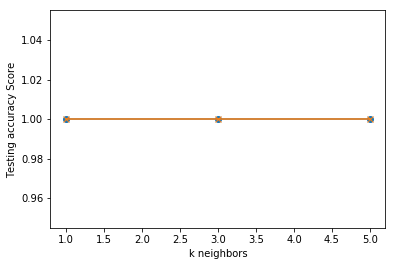

In [114]:
# PLOT KNN SCORES
plt.plot(range(1, 6, 2), train_scores, marker='o')
plt.plot(range(1, 6, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [115]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [116]:
print('k: 3, Test Acc: %.3f' % knn.score(X_test, y_test))

k: 3, Test Acc: 1.000


In [117]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [118]:
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1,5,10,50], 'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, verbose=3)
grid

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 5, 10, 50], 'gamma': [0.0001, 0.0005, 0.001, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [119]:
# Fit the model using the grid search estimator. 

grid.fit(X_train, y_train)

D:\Users\Black\Anaconda3\envs\PythonData2\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=1, gamma=0.0001 ...............................................
[CV] ..................... C=1, gamma=0.0001, score=1.0, total=   0.9s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ..................... C=1, gamma=0.0001, score=1.0, total=   0.9s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] ..................... C=1, gamma=0.0001, score=1.0, total=   1.0s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ..................... C=1, gamma=0.0005, score=1.0, total=   0.9s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ..................... C=1, gamma=0.0005, score=1.0, total=   0.9s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ..................... C=1, gamma=0.0005, score=1.0, total=   1.0s
[CV] C=1, gamma=0.001 ................................................
[CV] ...................... C=1, gamma=0.001, score=1.0, total=   0.9s
[CV] C=1, gamma=0.001 ................................................
[CV] ...................... C=1, gamma=0.001, score=1.0, total=   0.9s
[CV] C=1, gamma=0.001 ................................................
[CV] ...................... C=1, gamma=0.001, score=1.0, total=   1.0s
[CV] C=1, gamma=0.005 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 5, 10, 50], 'gamma': [0.0001, 0.0005, 0.001, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [120]:
print(grid.best_params_)

{'C': 1, 'gamma': 0.0001}


In [121]:
print(grid.best_score_)

1.0


In [122]:
start = time.time()
predictions = grid.predict(X_test)
end = time.time()

elapsed = end - start
print("PredictionDuration (msecs):", elapsed)
print("TimeDivision (msecs):", 1000*elapsed/len(X_test))



PredictionDuration (msecs): 0.1485764980316162
TimeDivision (msecs): 0.0021158715185362604


In [123]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names = ["lying", "standing", "walking", "running"]))

              precision    recall  f1-score   support

       lying       1.00      1.00      1.00     18051
    standing       1.00      1.00      1.00     17383
     walking       1.00      1.00      1.00     22118
     running       1.00      1.00      1.00     12668

   micro avg       1.00      1.00      1.00     70220
   macro avg       1.00      1.00      1.00     70220
weighted avg       1.00      1.00      1.00     70220



In [90]:
# KERAS MODEL

In [172]:
import os
import csv
import sys

from scipy import fftpack
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K


In [173]:
np.random.seed(123)

activityType = ["1", "2", "3", "4", "5", "6", "7", "12", "13"]
idList = range(len(activityType))
activityIdDict = dict(zip(activityType, idList))

In [174]:
def read(data_path, person_data):
    print('Reading Data...')
    files = os.listdir(data_path)
    for f in files:
        temp = f.replace('subject','').replace('.dat','')
        user = temp
        reader = csv.reader(open(os.path.join(data_path, f), "r"), delimiter=" ")
        for row in reader:
            if 'NaN' not in row[10:13] and 'NaN' not in row[27:30] and 'NaN' not in row[44:47]:
                instance = []
                instance.extend([float(t) for t in row[10:13]])
                instance.extend([float(t) for t in row[27:30]])
                instance.extend([float(t) for t in row[44:47]])
                activity = row[1]
                if activity in activityType:
                    if user in person_data:
                        activity_data = person_data[user]
                        if activity in activity_data:
                            temp = activity_data[activity]
                            temp.append(instance)
                            activity_data[activity] = temp
                        else:
                            temp = []
                            temp.append(instance)
                            activity_data[activity] = temp
                        person_data[user] = activity_data
                    else:
                        temp = []
                        temp.append(instance)
                        activity_data = {}
                        activity_data[activity] = temp
                        person_data[user] = activity_data
    return person_data

In [175]:
def read_data():
    data_path = 'PAMAP2_Dataset/Protocol'
    person_data = {}
    person_data = read(data_path,person_data)
    print("Loaded: ",data_path)
    #data_path = 'PAMAP2_Dataset/Optional'
    #person_data = read(data_path,person_data)
    #print("Loaded: ",data_path)
    return person_data

In [176]:
def extract_features(person_data, window_length=500, ndct=60):
    hand_data = []
    chest_data = []
    ankle_data = []
    labels = []
    for person in person_data:
        for activity in person:
            df = person[activity]
            act = activityIdDict.get(activity)
            hands, chests, ankels= split_windows(df, window_length)
            hand_data.extend(hands)
            chest_data.extend(chests)
            ankle_data.extend(ankels)
            labels.extend([act for i in range(len(hands))])
    dct_hand_data = dct(hand_data, ndct)
    dct_chest_data = dct(chest_data, ndct)
    dct_ankle_data = dct(ankle_data, ndct)
    return dct_hand_data, dct_chest_data, dct_ankle_data, labels

In [177]:
def split_windows(data, window_length):
    modal1 = []
    modal2 = []
    modal3 = []
    i = 0
    N = len(data)
    while i + window_length < N:
        start = i
        end = start + window_length
        modal_1 = [a[:3] for a in data[start:end]]
        modal_2 = [a[3:6] for a in data[start:end]]
        modal_3 = [a[6:9] for a in data[start:end]]
        i = int(i + int(window_length/5))
        modal1.append(modal_1)
        modal2.append(modal_2)
        modal3.append(modal_3)
    return modal1, modal2, modal3

In [178]:
def dct(windows, ndct):
    dct_window = []
    for tw in windows:
        x = [t[0] for t in tw]
        y = [t[1] for t in tw]
        z = [t[2] for t in tw]

        dct_x = np.abs(fftpack.dct(x, norm='ortho'))
        dct_y = np.abs(fftpack.dct(y, norm='ortho'))
        dct_z = np.abs(fftpack.dct(z, norm='ortho'))

        v = np.array([])
        v = np.concatenate((v, dct_x[:ndct]))
        v = np.concatenate((v, dct_y[:ndct]))
        v = np.concatenate((v, dct_z[:ndct]))

        dct_window.append(v)

    dct_window = np.array(dct_window)
    return dct_window


In [179]:
def build_Kerasencoder():
    input = Input(shape=(180,))
    encoded = Dense(96, activation='sigmoid')(input)
    decoded = Dense(180)(encoded)
    model = Model(inputs=input, outputs=decoded)
    return model

In [180]:
person_data = read_data()
instance_ids = list(person_data.keys())
index = instance_ids[0]
test_cases = [index]
train_cases = [ind for ind in instance_ids if ind not in test_cases]
train_data = [value for key, value in person_data.items() if key in train_cases]
test_data = [value for key, value in person_data.items() if key in test_cases]

test_hands, test_chests, test_ankles, test_y = extract_features(test_data, window_length=500, ndct=60)
train_hands, train_chests, train_ankles, train_y = extract_features(train_data, window_length=500, ndct=60)
    
test_hands = np.array(test_hands, dtype=np.dtype('Float64'))
test_chests = np.array(test_chests, dtype=np.dtype('Float64'))
test_ankles = np.array(test_ankles, dtype=np.dtype('Float64'))
test_y = np.array(test_y, dtype=np.dtype('Float64'))
train_hands = np.array(train_hands, dtype=np.dtype('Float64'))
train_chests = np.array(train_chests, dtype=np.dtype('Float64'))
train_ankles = np.array(train_ankles, dtype=np.dtype('Float64'))
train_y = np.array(train_y)
    
    
print("train_hands: ")
print(train_hands)
print("train_chests: ")
print(train_chests)
print("train_ankles: ")
print(train_ankles)
print("train_y: ")
print(train_y)

Keras_model = build_Kerasencoder()
adam = Adam(lr=0.001)

Reading Data...
Loaded:  PAMAP2_Dataset/Protocol
train_hands: 
[[2.01751364e-01 8.96394972e-02 9.58772211e-02 ... 1.67819538e-02
  3.17265314e-02 1.88521656e-02]
 [2.85287916e-01 6.60777037e-02 6.88812868e-02 ... 3.09274753e-02
  5.08066238e-03 3.53339509e-03]
 [2.77559501e-01 2.42130881e-03 2.56000573e-02 ... 1.66693689e-02
  1.23508713e-02 3.59283148e-03]
 ...
 [5.58761892e+00 6.11830279e+00 1.05742324e-01 ... 1.15993188e-01
  2.87335869e-01 5.05851569e-01]
 [4.24692827e+00 4.74637293e+00 4.90917554e+00 ... 5.66403217e-01
  4.94707937e-01 4.09101365e-01]
 [7.69714597e-02 1.45544854e-01 1.11966188e-01 ... 5.05018186e-02
  7.65712706e-03 1.28490687e-03]]
train_chests: 
[[0.03947858 0.18326345 0.31070747 ... 0.05103762 0.02894111 0.02153759]
 [0.01860873 0.22357014 0.19252168 ... 0.02824072 0.03551731 0.03752578]
 [0.04168005 0.10855643 0.39513571 ... 0.04109974 0.05719824 0.02118656]
 ...
 [0.05789877 0.13990432 0.53382298 ... 0.17493414 0.26079668 0.05327943]
 [0.70628441 1.42677934 0

D:\Users\Black\Anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':
D:\Users\Black\Anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  del sys.path[0]
D:\Users\Black\Anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
D:\Users\Black\Anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  from ipykernel import kernelapp as app
D:\Users\Black\Anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Numeric-style type codes are deprecated and will res

In [181]:
Keras_model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])

Fitting Model For History:  0
Start Loss:  10.88936768227331


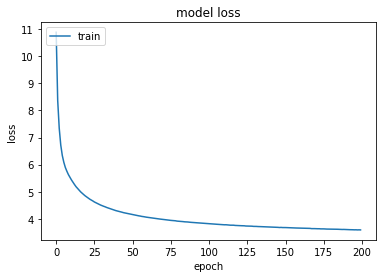

Fitting Model For History:  1
Start Loss:  3.5836599903599717


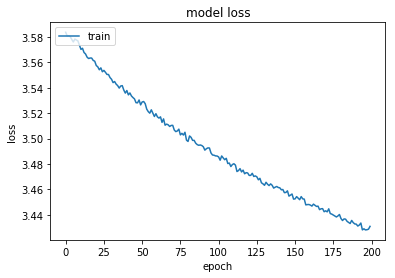

In [163]:
for i in range(2):
    print("Fitting Model For History: ", i)
    history = Keras_model.fit(train_hands, train_ankles, verbose=0, epochs = 200, shuffle = True)
    print("Start Loss: ", history.history['loss'][0])
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show() 
        

In [164]:
Keras_model.summary()

start = time.time()
predict_labels = Keras_model.predict(test_hands)
end = time.time()
elapsed = end - start
print(predict_labels)
print("PredictionDuration (msecs):", elapsed)
print("TimeDivision (msecs):", 1000*elapsed/len(test_hands))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 180)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 96)                17376     
_________________________________________________________________
dense_30 (Dense)             (None, 180)               17460     
Total params: 34,836
Trainable params: 34,836
Non-trainable params: 0
_________________________________________________________________
[[ 2.8299747   1.9649936   2.587556   ...  0.10890254  0.12184913
   0.23842746]
 [ 1.5963966   1.3936079   1.637161   ...  0.12074816  0.10958852
   0.10874915]
 [-0.9785578   0.0919494  -0.36496806 ...  0.15443283  0.11346929
   0.05664647]
 ...
 [ 2.0109942   1.389423    2.0935016  ...  1.7353308   2.034479
   1.5620263 ]
 [ 2.0526853   1.906994    1.6199334  ...  1.103224    1.3819085
   0.95398

In [166]:
#confusion_matrix(predict_labels, train_y, ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic walking', 'ascending stairs', 'descending stairs'], "Confusion Matrix for Keras encoded model using position features only")
    

In [167]:
# SAVE KERAS MODEL

In [20]:
Keras_model.save("model/Keras__model.h5")

In [171]:
Keras_model.save_weights("model/Keras__model_weights.h5")